In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys 

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)

import math
import time
from datetime import datetime
from random import shuffle
from statistics import mean
from typing import Tuple, List

import pandas as pd

from ams.DateRange import DateRange
from ams.config import constants
from ams.services import ticker_service
from ams.services.EquityFields import EquityFields
from ams.services.ticker_service import get_nasdaq_info, get_ticker_eod_data
from ams.utils import date_utils
import seaborn as sns

In [36]:
def get_nas_perf(from_str: str, to_str: str):
    # Arrange
    days_hold_stock = 1

    date_from = date_utils.parse_std_datestring(from_str)
    date_to = date_utils.parse_std_datestring(to_str)
    
    print(f"Getting {from_str}-{to_str}")
    
    df, tickers = sample_roi(date_from=date_from, date_to=date_to, days_hold_stock=days_hold_stock)
    
    return df, tickers


def sample_roi(date_from: datetime, date_to: datetime, days_hold_stock: int):
    df_tickers = get_nasdaq_info()
    tickers = df_tickers["ticker"].to_list()
    shuffle(tickers)

#     tickers = tickers[:math.ceil(len(tickers) / 2)]

    # Act
    df, tickers = ticker_service.get_nasdaq_perf(date_from=date_from,
                                                  date_to=date_to,
                                                  min_price=None,
                                                  max_price=3.0,
                                                  tickers=tickers,
                                                  days_hold_stock=days_hold_stock)
    
    return df, tickers


def test_roi():
    # Arrange
    # Act

    num_years = 1
    roi_all = []
    start_year = 19
    for year in range(start_year, start_year + num_years):
        from_str = f"20{year:02d}-01-01"
        to_str = f"20{year:02d}-12-31"
        days_hold_stock = 4
        roi = find_roi(from_str, to_str, days_hold_stock)
        roi_all.append(round(roi, 3))

    print(roi_all)


def find_roi(from_str, to_str, days_hold_stock):
    df = pd.read_parquet(constants.DAILY_ROI_NASDAQ_PATH)
    df = df[df["date"] > from_str]
    df = df[df["date"] < to_str]

    print(f"\n\nROI mean of means: {df['roi'].mean():.4f}")

    df.sort_values(by=["date"], inplace=True)

    roi_list = df["roi"].to_list()

    roi_list = [r for ndx, r in enumerate(roi_list) if ndx % days_hold_stock == 0]
    chunked_rois = list(chunks(roi_list, days_hold_stock))

    roi_list = []
    for c in chunked_rois:
        _, roi = roi_calc(c)
        roi_list.append(roi)

    num_days = len(roi_list)
    print(f"Number of trading days: {num_days}")

    to_zero = list(range(num_days))
    shuffle(to_zero)

    total_stocks = 6600
    tot_to_zero = math.ceil((156 / 365) * num_days)
    tot_to_zero = math.ceil(tot_to_zero * (tot_to_zero / total_stocks))
    print(f"Total to zero trades: {tot_to_zero}")
    to_zero = to_zero[:tot_to_zero]

    risk_per_trade = tot_to_zero / total_stocks

    num_simul_trades = 8
    total_trades = num_days * num_simul_trades
    total_trades_bunked = total_trades * risk_per_trade
    print(f"risk_per_trade: {risk_per_trade:.4f}")
    print(f"Total trades: {total_trades}")
    print(f"Total trades bunked: {total_trades_bunked:.4f}")
    investment, roi = roi_calc(roi_list)

    print(f"ROI: {roi:.2f}: Investment: {investment:.2f}")

    return roi

In [37]:
def raw_invest(from_str: str, to_str: str, tickers: List[str]):
    shuffle(tickers)

    diffs = []
    for t in tickers:
        df = get_ticker_eod_data(t)
        df = df[(df["date"] > from_str) & (df["date"] < to_str)]
        df.sort_values(by=["date"], inplace=True)
        start_close_value = df.iloc[0]["close"]
        end_close_value = df.iloc[-1]["close"]
        diffs.append((end_close_value - start_close_value) / start_close_value)
    
    return diffs


def calc_variance(diffs):
    mean_diff = mean(diffs)
    sum_sq_diff = 0
    for d in diffs:
        sq_diff = (d - mean_diff) ** 2
        sum_sq_diff += sq_diff
    variance = math.sqrt(sum_sq_diff / (len(diffs)))
    return variance


def roi_calc(roi_list: List[float]):
    init_inv = 100
    investment = init_inv
    for ndx, r in enumerate(roi_list):
        investment = (investment * r) + investment
        if investment < 0:
            investment = 0
    return investment, (investment / init_inv) - 1


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [41]:
num_years = 1
roi_all = []
start_year = 20
for year in range(start_year, start_year + num_years):
    from_str = f"20{year:02d}-01-01"
    to_str = f"20{year:02d}-12-31"
    print(f"\n{from_str} thru {to_str}")
    _, tickers = get_nas_perf(from_str=from_str, to_str=to_str)
    year_tickers = list(tickers)

    price_changes = raw_invest(from_str=from_str, to_str=to_str, tickers=year_tickers)

    variance = calc_variance(price_changes)

    print(f"{mean(price_changes):.3f}; variance: {variance}")
        


2020-01-01 thru 2020-12-31
Getting 2020-01-01-2020-12-31
0.995; variance: 3.5717738077616623


In [34]:
year = start_year
from_str = f"20{year:02d}-01-01"
to_str = f"20{year:02d}-12-31"

year_2010_tickers = ['SVAFF', 'CFCB', 'LOOK', 'ABVA', 'ORFR', 'IIN', 'VPGC', 'AUTH', 'IPT', 'WWAY', 'XRIT', 'BSQR', 'FORBQ', 'FESLQ', 'BKRSQ', 'NVDQ', 'BPTR', 'SINO', 'AMOT', 'HEIIQ', 'CALCQ', 'PFCO', 'AFFI', 'AWRE', 'ITIG', 'ATHX', 'ESCI', 'ENHT', 'CIMT', 'SUPR', 'LJPC1', 'AERT', 'TCX', 'RPRX', 'TRBN', 'PACR', 'ACMR1', 'CMKG', 'TGISQ', 'ATRN', 'SBLUQ', 'MERC', 'SBKC', 'TNSB', 'SPNT', 'FCVA', 'SCLD', 'FNLYQ', 'FLWS', 'BREW', 'PARL', 'CTHR', 'BCAS', 'EBHIQ', 'REVU', 'NOEC', 'GGBMQ', 'ATRS', 'ACTS', 'INOD', 'FCFL', 'SLTM', 'VRME', 'NGEN', 'CALL1', 'TECJQ', 'SSTI1', 'ZIOP', 'PDRT', 'ESCA', 'WTSL', 'INVC', 'STRZA', 'CHMP', 'ZIOP', 'CYAN', 'NYMX', 'ICGN', 'BTFG', 'LOGC1', 'SNFCA', 'FOLD', 'ACAS', 'DDDC', 'NHWK', 'AXDX', 'QUOT1', 'HQI', 'CDIR', 'ORFR', 'SIEB', 'SIFY', 'SPORQ', 'STRC', 'ARIS', 'FCVA', 'HMNF', 'MTSXY', 'APWC', 'ACHN', 'PFIE', 'STHKQ', 'LIOX', 'HYDGQ', 'DLIA', 'CHYR', 'OPTI', 'AMFIQ', 'NMTI', 'CRWS', 'WITM', 'OCC', 'LEDR', 'BYLK', 'CERS', 'ATSG', 'EDUC', 'VNWI', 'VCGH', 'SBKC', 'MARK', 'CEXE', 'SCEI', 'ITCD', 'ARGA', 'MSII', 'DVID', 'CBKN', 'SYPR', 'LENS1', 'PARL', 'JADE', 'KERX', 'ASRV', 'CHTP', 'WSGI', 'RBPAA', 'ALGI', 'CRWN', 'IRWNQ', 'BAANF', 'CTSO', 'MASC', 'TIII', 'FUELQ', 'REFR', 'CGUE', 'ATBC', 'VTSS', 'AUTH', 'SCLD', 'HIHO', 'VERA', 'NHWK', 'BNSO', 'TAIT', 'FESLQ', 'MNDO', 'SPCHB', 'OMTL', 'VRCC', 'UIHC', 'NSSC', 'AWRE', 'ONSM', 'COA1', 'CGCP', 'BYFC', 'NBIX', 'WALK', 'IDIX', 'BSMD', 'DANKY', 'FRGBQ', 'CPSS', 'HTRN', 'HLCSQ', 'CLBH', 'MACC', 'DLHC', 'WEST', 'INOD', 'DUSA1', 'VAPHQ', 'TRNT', 'PHHMQ', 'WSCI', 'DPAC', 'AGNT', 'GOLF1', 'PXLW', 'SCLN', 'CASM', 'CALP', 'NAVI1', 'CVLL', 'WRESQ', 'APWC', 'BJCT', 'MSON', 'ONVI', 'MAMS', 'FSNMQ', 'KERX', 'ZYXI', 'CPSH', 'AMARQ', 'KNDI', 'MTSN', 'ITI', 'NAMC', 'ARTX', 'OISI', 'VOXW', 'SMDK', 'ASTTY', 'OCHTQ', 'WOLF', 'BYLK', 'SYNX', 'CBBO', 'GOLF1', 'BBND', 'IMMCQ', 'MCOAQ', 'GALT', 'ADVNQ', 'ASRT', 'ASAL', 'PBAL1', 'RFMI', 'LPTH', 'SURG', 'FMFC', 'LJPC1', 'MCBC', 'SIFY', 'NVDQ', 'UCFC', 'NOEC', 'HOTJ1', 'AUTO1', 'UAHC', 'UAHC', 'MAGS', 'IMOS1', 'LTONY', 'BWTR', 'MIIX', 'ORCH', 'FPFX', 'VRME', 'PANC', 'ADES', 'TTHI', 'USIO', 'LTRX', 'FFEX', 'HILL', 'TBSI', 'RGDX', 'EDUC', 'RDNT', 'GRAN', 'BOFLQ', 'TLCVF', 'SPNS', 'BIDZ', 'VIFL', 'MAXW', 'RAND', 'SMVE', 'FCAL1', 'RHIEQ', 'ALGI', 'ROSD', 'MEET', 'CCGM', 'PTEK', 'POCC', 'SGRP', 'JPST1', 'ATHYQ', 'ARIA', 'AHCI', 'ICCC', 'LDIS', 'ECNG', 'COSN', 'OCC', 'IMBI', 'NGAS', 'TRMPQ', 'NGEN', 'LUNA', 'GRNB1', 'WLKR', 'IPII', 'API', 'MESAQ', 'CNVR1', 'CTZN', 'BKYI', 'GFN', 'URGP', 'EVSNF', 'QSND', 'TCMI', 'CPCIQ', 'VITK', 'SCOXQ', 'HOKU', 'FNET', 'TXCOQ', 'FNLYQ', 'PRPH', 'MIPIQ', 'KNDI', 'HNNA', 'ANSV', 'FMARQ', 'TOMO', 'PXPLY', 'TXCOQ', 'MTSN', 'TFCO', 'IBLTZ', 'EMAKQ', 'CERS', 'PVFC', 'LEDR', 'ORBT', 'SYNB', 'TISA', 'IDEX', 'CAMT', 'STRZA', 'SHOEQ', 'CLFD', 'HTCH', 'NRDS', 'SCMF', 'CYBI', 'RMIXQ', 'SNKTY', 'AFOP', 'CALAQ', 'OSTE', 'LIOX', 'TUNE', 'VOXW', 'BIKEQ', 'PDRT', 'PFCO', 'ACII', 'AHII1', 'FFSX', 'MBRKQ', 'CVNSQ', 'CWBC', 'GEEK', 'ASRT', 'PRLS', 'ESXB', 'TBAC', 'CASB', 'SCOXQ', 'STHKQ', 'CRTN', 'STEN', 'DTRX', 'NYER', 'BCLI', 'ENTN', 'MARK', 'BBLUQ', 'MCBC', 'TONEQ', 'CJBK', 'ECTYQ', 'DEIX', 'CYDEQ', 'TDBK', 'MRGE1', 'SLRY', 'MSLI', 'TCCC', 'ANLY', 'MAXW', 'ISCIQ', 'FSII', 'MADGQ', 'CLBH', 'HRZB', 'ACAD', 'LFVN', 'ADLR', 'ESXB', 'WPEC1', 'SMMF', 'CASB', 'EEEI', 'AMGI', 'BPTR', 'NZYM', 'STRM', 'PFIN', 'CBBO', 'FPBN', 'INHX', 'NCST', 'RPTP', 'DXLG', 'CYRN', 'NAMC', 'III', 'SOAP', 'PACI', 'EBHIQ', 'GMET', 'CYDS', 'STBK', 'MBTF', 'TRXI', 'NPLA', 'SSTI1', 'ORBC', 'ATRN', 'IACH', 'STRC', 'PCYO', 'AIMM', 'ABDS', 'GMAB', 'REVU', 'KDUS', 'MAGS', 'EILL', 'IBCP', 'AXTI', 'SLP', 'EDGR', 'ARCW', 'ICOPQ', 'GRRF', 'UCFC', 'JCTCF', 'BLDP', 'TIII', 'CAMH', 'CNLG', 'SSBX', 'PCYO', 'UPFC', 'SPCHB', 'BKUNQ', 'SOHO', 'CEMI', 'ATHYQ', 'ANNB', 'APYX', 'EVK', 'KONA', 'NSYS', 'MOKO', 'FMTIF', 'IFLG', 'PVFC', 'AMRN', 'RFMI', 'BWEBF', 'LIQWF', 'TCCC', 'GDEN', 'AHII1', 'RPRX', 'ADUS', 'TRIS', 'CNXT1', 'RSSS', 'CVBK', 'SOCB', 'CLFD', 'INPHQ', 'WGLF', 'ABDS', 'OSBCP', 'ROHIQ', 'TSG', 'CDXC', 'DYAX', 'AMARQ', 'SVBI', 'PLBC', 'CEMI', 'CPBK', 'DXYN', 'SMTX', 'ORBT', 'ATTU', 'ADMP', 'OPMR', 'CNVR1', 'CAVO', 'XINGF', 'NEST', 'PINN', 'LPTH', 'BFNB', 'FFNM', 'BLDR', 'SIRI', 'PDEX', 'FCFL', 'TRMAQ', 'CVBK', 'TRCB', 'NTEC1', 'RSSS', 'SERV1', 'RVSB', 'CHRS1', 'EMAKQ', 'HEIIQ', 'ORXE', 'DSKX', 'CAMH', 'TARRQ', 'NEI', 'ENTN', 'NSFC', 'CADMQ', 'TGISQ', 'ICOPQ', 'TECJQ', 'CNXT1', 'AIMM', 'BDSI', 'ASTX', 'REMC', 'KOPN', 'WGATQ', 'FOOD1', 'AVCS', 'RNGY', 'PLPM', 'ACAS', 'KUTV', 'HIST', 'CNTY', 'SLRY', 'NGAS', 'SPRO1', 'ENHT', 'AVCS', 'TLGT', 'GTIM', 'ATLC', 'KSW', 'BOFLQ', 'PBAL1', 'CYRN', 'IPT', 'HYPRQ', 'CPWM', 'NAVI1', 'VG', 'EDAP', 'AWBCQ', 'MGIC', 'WTSL', 'RINO', 'AXST', 'DTIIQ', 'RMTR', 'CRTP', 'PABK', 'NWK', 'LMLP1', 'QSND', 'HGSH', 'INOW', 'QMRK', 'COSIQ', 'ZIXI', 'ACME', 'FENC', 'BUTLQ', 'HOKU', 'SMTX', 'MGXX', 'SNDTF', 'IMMCQ', 'FLDR1', 'FLOW1', 'TDBK', 'AFFMQ', 'HIST', 'GLDUQ', 'TFCO', 'ERS', 'SNKI', 'ADLR', 'TCLIF', 'COBR', 'IDEX', 'FLL', 'DUSA1', 'VTNR', 'TAMB', 'SBFG', 'DTLK', 'AATI', 'UPI', 'IIN', 'HPOL', 'VITA', 'HNIN', 'MERC', 'WITM', 'GLOV', 'TRCH', 'PABK', 'ISWI', 'HRVEQ', 'WGLF', 'MYTNQ', 'RUTH', 'CSCX', 'TRMPQ', 'WLDN', 'SNKI', 'RDCM', 'ACHN', 'RITT', 'SHSO', 'BDSI', 'HRVEQ', 'EUBK', 'NGBF', 'GFN', 'TAMB', 'GMAB', 'UPFC', 'LOAN', 'GTCB', 'HNNA', 'ADEP', 'SANWZ', 'BBND', 'FXEN', 'TBHS', 'MNTG', 'FONR', 'MAXC', 'RDCM', 'ESIMF', 'PPCO', 'CLRO', 'APAB', 'SNAK', 'IBIS', 'NSFC', 'CVLL', 'HDSN', 'ATPL', 'CPSS', 'DDDC', 'FLOW1', 'BSMD', 'ECTX1', 'MBHIQ', 'BJCT', 'SNTS', 'VRCC', 'SNTO', 'AXGN', 'ATSI', 'ABWG', 'USHS', 'NEO', 'ATSI', 'GTOPQ', 'SKYL', 'CTIB', 'RVSB', 'SIMG', 'ROAC', 'EEEI', 'RAVE', 'MDWV', 'NSSC', 'WCSTF', 'DEIX', 'IMMU', 'OPTI', 'QXMCF', 'BLDR', 'LOGC1', 'ACTT1', 'BHBCQ', 'IMBI', 'MYTNQ', 'NCST', 'APAB', 'SKYL', 'SVAFF', 'GEEK', 'ATLC', 'EFJI', 'VEXPQ', 'SYPR', 'ESIC', 'HYDGQ', 'VPF', 'CAVO', 'CVNSQ', 'ANNB', 'MACC', 'CALAQ', 'NXXIQ', 'CSCX', 'TXCCQ', 'ABVA', 'SNAK', 'GMTC', 'SANW', 'ADGF', 'RMIXQ', 'CLAR1', 'WRLS1', 'ACTS', 'AAME', 'ICCC', 'SMIT', 'OPK', 'DSCM', 'IDAI', 'UBET', 'SNKTY', 'JDOGQ', 'RINO', 'UNXL', 'SCKT', 'BCDA', 'AFFMQ', 'MGXX', 'SCLN', 'INTZ', 'AVMC', 'ATRS', 'CHZS', 'IRIX', 'XRSC', 'USPI2', 'ISEE1', 'FRBA', 'MSTX', 'HWFGQ', 'FCEN', 'CJHBQ', 'CADMQ', 'EDAP', 'CAMT', 'CTSO', 'DEAR', 'PTSX', 'NTEC1', 'EGAN', 'OSBC', 'CMVT', 'TIGR1', 'URGP', 'LENS1', 'ARRY', 'MIPIQ', 'BWTR', 'MEAD', 'BLFS', 'JMAR', 'PPTV', 'DPAC', 'MBND', 'HEROQ', 'OESX', 'MMAC', 'PRLS', 'FPBI', 'DEAR', 'WGNB', 'XPRT', 'MDWV', 'AMFIQ', 'BNVIQ', 'HIHO', 'IDIX', 'SDBT', 'XWES', 'TTIL', 'FACE', 'CAMP', 'STXX1', 'SMVE', 'AXIHQ', 'AVNR', 'QELP', 'NPLA', 'UIHC', 'HNIN', 'DSWL', 'LTRX', 'ASUR', 'SAMB', 'FPBN', 'WWAY', 'OCHTQ', 'NEPT', 'OISI', 'ATHX', 'NZYM', 'ISWI', 'SANW', 'PINN', 'MASC', 'TCMI', 'BUTLQ', 'ENG', 'FORD', 'WPEC1', 'VYFC', 'EVK', 'BWEBF', 'XETA', 'FLL', 'NHLD', 'FPBI', 'TRNIQ', 'CYPB', 'AMGI', 'HGSH', 'KUTV', 'DSCM', 'BTFG', 'MMAC', 'ATTY', 'EPIX1', 'GNTA', 'ARGA', 'PACI', 'FRGBQ', 'TPPPF', 'ARIA', 'CMVT', 'ENCO', 'ELXS', 'TSTRQ', 'SNMX', 'WAVE', 'TMBLQ', 'MECAQ', 'WTCT', 'IISX', 'IMOS1', 'CORT', 'MKTSQ', 'VLNCQ', 'SPCB', 'WSCI', 'ISTA', 'CRYP', 'TPPPF', 'UGNEQ', 'BAANF', 'ANDS', 'USIO', 'PTEC', 'DRUG', 'FRBK', 'TBUSQ', 'XRSC', 'MSVP', 'CEXE', 'AMIEQ', 'OSTE', 'SEMIQ', 'MECAQ', 'RPTP', 'ONAVQ', 'CPBRQ', 'TRIS', 'PTSX', 'MNDO', 'CALCQ', 'CDII', 'SCEI', 'FPFCQ', 'CPSH', 'MCBI1', 'UWBKQ', 'MCOAQ', 'BAXS', 'CWBS', 'GAFC', 'MDTL', 'CORSQ', 'NEXC', 'OCZTQ', 'INBK', 'ACMR1', 'NWK', 'MNTX', 'ASTX', 'SLP', 'LTONY', 'GTAX', 'COOPQ', 'SINO', 'VETS1', 'HLCSQ', 'PCBS', 'DAEG', 'SMMF', 'BKUNQ', 'LNETQ', 'SIMG', 'BASI', 'CXPO', 'AXGN', 'AUDC', 'SOAP', 'ANSV', 'DIGL', 'XRIT', 'WEB', 'VTNR', 'MTMC', 'RMTR', 'CASM', 'GENTY', 'HDSN', 'MDNU', 'WHRT', 'APPS', 'ANPIQ', 'IACH', 'CPBK', 'AERT', 'XTEL', 'SIMO', 'AMRN', 'CASI', 'AHCI', 'MEET', 'FFEX', 'NINE1', 'WBNK', 'ZIPR', 'TEKCQ', 'PTEK', 'XOHO', 'PFSW', 'COBR', 'OPTV', 'CAFI', 'LINK', 'ARTX', 'GGBMQ', 'BFNB', 'CRWS', 'ITI', 'BTIOQ', 'VEXPQ', 'VFNX', 'AXIHQ', 'FNET', 'QUSA', 'INOC', 'DENN', 'TSTRQ', 'AMIEQ', 'WLDN', 'HEVVQ', 'GTAX', 'CMRO', 'UONE', 'EDGW', 'MTSXY', 'MDIZQ', 'SCMF', 'ASUR', 'GLOV', 'ENCO', 'MPVD', 'CJBK', 'SURG', 'FRCMQ', 'TRCB', 'SVLF', 'ZARLF', 'REFR', 'AMOT', 'WCAP', 'SNEN', 'PMBC', 'ESIMF', 'REMC', 'KDUS', 'RITT', 'CHRD', 'SHSO', 'BCAR', 'PRST', 'ZANE', 'RHIEQ', 'ISTA', 'ACTT1', 'WRLS1', 'VITA', 'TSG', 'ZIPR', 'RGDX', 'WCSTF', 'QUIK', 'STBK', 'MAMS', 'WSBF', 'HYPRQ', 'FORD', 'GENTY', 'FMARQ', 'PMBC', 'LDIS', 'MHCO', 'FSII', 'DITC', 'MRXLY', 'ABCD', 'GLDC', 'DISK', 'GLDC', 'CCBD', 'DRUG', 'AFFI', 'TONEQ', 'CNLG', 'EGHDQ', 'PAET', 'ARRY', 'YORK', 'RNGY', 'INGNQ', 'SSCCQ', 'DLHC', 'QMRK', 'ASFN', 'INVC', 'ABPI', 'DATX', 'AFOP', 'AEHR', 'IBCP', 'SYNX', 'OPXT', 'PACR', 'API', 'FCEN', 'PPTV', 'SEV', 'TXCCQ', 'RAVE', 'TRIDQ', 'ATSG', 'MBRX1', 'JADE', 'MFI', 'WHLM', 'MBRKQ', 'ZANE', 'CPRX', 'JFBI', 'SMTB', 'AVMC', 'LINK', 'MOKO', 'HOLL', 'SOHO', 'ENTP', 'ALRN1', 'ADMP', 'TFINQ', 'GNTA', 'PATK', 'SWWI', 'SALM', 'APPS', 'FVE', 'SNTS', 'ECTYQ', 'BIDZ', 'NCMV', 'ISON', 'CDXC', 'INTZ', 'ITSI', 'TBAC', 'ESCC', 'SSFC', 'NBIX', 'TUNE', 'ASFN', 'NXXIQ', 'DCGNQ', 'RGCIQ', 'FVE', 'DCGNQ', 'BASI', 'XTEL', 'WSGI', 'TRMAQ', 'CIIC', 'HTCH', 'TSFG', 'GLUU', 'MBHIQ', 'STKL', 'VRNM', 'CALD', 'PLNR', 'PCBI', 'TFINQ', 'APDN', 'RDNT', 'OPK', 'MNTX', 'BCAR', 'EDGW', 'PHHMQ', 'VIFL', 'SPNS', 'XINGF', 'JCTCF', 'HQI', 'QELP', 'GTCB', 'ATEA', 'MIIX', 'AWBCQ', 'SALM', 'MPVD', 'ADVNQ', 'HLYS', 'INHX', 'DATX', 'CGCP', 'OPTV', 'BYFC', 'WGNB', 'HCKT', 'TBUSQ', 'DITC', 'CIIC', 'CASA1', 'SIRI', 'PLNR', 'ZAAP', 'CALL1', 'ESIC', 'VTSS', 'KINS', 'IDAI', 'AGNT', 'ANPIQ', 'ASBI', 'UPI', 'CHMP', 'PAET', 'RCMT', 'PROV', 'CBKN', 'ECNG', 'TCX', 'PRST', 'CHNL', 'NOOF', 'LSCC', 'NEST', 'HMNF', 'NYER', 'BFSB', 'TLGT', 'FORBQ', 'ABWG', 'OSBC', 'CMKG', 'BSQR', 'RVSIQ', 'ONAVQ', 'ASAL', 'HEROQ', 'OSCI', 'WSB', 'CAMP', 'OPMR', 'FFSX', 'EGHDQ', 'MDVN', 'NEPT', 'SGRP', 'NYMX', 'CASI', 'GDEN', 'DVID', 'FPFCQ', 'BIKEQ', 'ZAGG', 'MFI', 'SAAS', 'AEY', 'CALD', 'CTZN', 'TRNT', 'DENN', 'FLSCQ', 'OHBIQ', 'NBBC', 'STEN', 'CCGM', 'ESCI', 'NMTI', 'SSCCQ', 'CALP', 'UBFO', 'GLUU', 'ACTI', 'GLOB1', 'KNTH', 'SMTB', 'USHS', 'NEXC', 'NOVT', 'LMLP1', 'BHBCQ', 'PROV', 'OESX', 'STXX1', 'ABPI', 'VCGH', 'WHRT', 'CFCB', 'FACE', 'AXDX', 'ANDS', 'IMMU', 'AXST', 'NSYS', 'MCBI1', 'ANTP', 'MESAQ', 'PPCO', 'SNFCA', 'AEHR', 'GLOB1', 'AHOM', 'PDEX', 'HOLL', 'PYMX', 'OMNI', 'UNXL', 'PLPM', 'WCAP', 'ANLY', 'DRRX', 'MSTX', 'PFIN', 'CJHBQ', 'NHLD', 'SVBI', 'ANTP', 'VNWI', 'VG', 'KINS', 'DOVR', 'CHRS1', 'EMMS', 'NCOC', 'CPBRQ', 'RFIL', 'ISEE1', 'GAFC', 'XPRT', 'LNETQ', 'NSTR', 'FUELQ', 'EMDAQ', 'ASTTY', 'FMFC', 'PNHNF', 'BCDA', 'VPGC', 'EXTR', 'XETA', 'PSTX', 'PRPL1', 'NOOF', 'DRRX', 'SWWI', 'ARIS', 'PSTX', 'WALK', 'ESCA', 'AUTO1', 'ACII', 'COOPQ', 'MITK', 'CORT', 'CLRO', 'SDNA', 'PXPLY', 'TAIT', 'SIEB', 'HIMX', 'AUDC', 'ORCT', 'XWES', 'PRPL1', 'IBNKQ', 'BFSB', 'CWBS', 'FOLD', 'CYAN', 'DXYN', 'KENT', 'INOC', 'CWBC', 'CPRX', 'TGICQ', 'CMRO', 'SIMO', 'WSBF', 'ORXE', 'TEKCQ', 'DTIIQ', 'MEMS', 'LAVA', 'ENG', 'RFIL', 'VAPHQ', 'SGMO', 'ACAD', 'PNHNF', 'EFJI', 'EMDAQ', 'USPI2', 'FONR', 'CDII', 'ATBC', 'EUBK', 'RAND', 'SNMX', 'DTRX', 'ONSM', 'MSII', 'PGICQ', 'AERG', 'XSELY', 'MBND', 'CLAR1', 'OBCI', 'NENA', 'ZYXI', 'CYCCP', 'FPFX', 'DLIA', 'EXTR', 'CXPO', 'EVOQ', 'TRXI', 'ORBC', 'MNTG', 'MHCO', 'AAME', 'UONEK', 'TCLIF', 'TSFG', 'GTOPQ', 'BCLI', 'ZPLSQ', 'WRESQ', 'BNSO', 'SMDK', 'COSN', 'CTHR', 'GTIM', 'SSMH', 'XSELY', 'NHTC', 'INBK', 'VRNM', 'JDOGQ', 'POCC', 'NHTC', 'RVSIQ', 'SDBT', 'WEB', 'IBIS', 'VITK', 'ITCD', 'WEST', 'PYMX', 'PCBI', 'MRGE1', 'ECTX1', 'FENC', 'CPWM', 'TRBN', 'BBLUQ', 'MDNU', 'ISCIQ', 'CAFI', 'HIMX', 'JFBI', 'XOHO', 'TRCH', 'NINE1', 'ODDJ', 'BBDC1', 'SAMB', 'CDIR', 'FXEN', 'NENA', 'ARCW', 'EXEL', 'KENT', 'ALRN1', 'NEO', 'VTRO1', 'MSEL', 'ADGF', 'QXMCF', 'NSTR', 'DISK', 'GRRF', 'GRNB1', 'CRTN', 'WAVE', 'LFVN', 'AVNR', 'SPORQ', 'CORSQ', 'ORCT', 'PAYS', 'DSKX', 'ADES', 'MEAD', 'OCZTQ', 'HILL', 'MSEL', 'FLWS', 'LOOK', 'ADUS', 'FCAL1', 'LAVA', 'LUNA', 'FTUSQ', 'EVOQ', 'INPHQ', 'NCOC', 'EDAC', 'SMIT', 'FLSCQ', 'VFNX', 'APDN', 'ENWV', 'AXAS', 'PFSW', 'FRBK', 'UWBKQ', 'RCMT', 'CIMT', 'ORCH', 'EXEL', 'ZIXI', 'ENTP', 'IBCA', 'SBFG', 'MAXC', 'KNTH', 'MDIZQ', 'CYDEQ', 'HRZB', 'BLDP', 'ROHIQ', 'RBPAA', 'ERS', 'KSW', 'CNTY', 'BKYI', 'OMNI', 'SEV', 'SNEN', 'MITK', 'AXTI', 'DWCH', 'OMTL', 'GALT', 'MSLI', 'WBNK', 'VPF', 'WSB', 'NBBC', 'KOPN', 'CYDS', 'EMMS', 'SUPR', 'SERV1', 'PTIX1', 'III', 'UONE', 'TOMO', 'NWRZ', 'OPXT', 'GEPT', 'SLTM', 'PXLW', 'CHYR', 'PTEC', 'COSIQ', 'VETS1', 'RUTH', 'HWFGQ', 'CPAH', 'SQBG', 'SQBG', 'FLDR1', 'TBSI', 'ATTY', 'HPOL', 'VIRC', 'PAYS', 'CRYP', 'TTHI', 'SPCB', 'STRM', 'KQIPQ', 'PGICQ', 'DANKY', 'ATEA', 'VERA', 'GEPT', 'NCMV', 'CHNL', 'DIGL', 'LOAN', 'OSCI', 'MDVN', 'SNTO', 'MTMC', 'PATK', 'HEVVQ', 'JMAR', 'MKTSQ', 'QUOT1', 'CRFT', 'PFIE', 'WOLF', 'EDGR', 'SEMIQ', 'AEY', 'ACME', 'TBSIQ', 'BREW', 'SCKT', 'MADGQ', 'OBCI', 'MDTL', 'SYNB', 'SGMO', 'TLCVF', 'SAAS', 'ZPLSQ', 'WTCT', 'CRTP', 'EGAN', 'DTLK', 'CHZS', 'PANC', 'BFLY', 'QUIK', 'CYBI', 'TTIL', 'ASBI', 'AHOM', 'IFLG', 'ABCD', 'TRBRQ', 'ATPL', 'GMTC', 'KONA', 'CYPB', 'ENWV', 'NRDS', 'DAEG', 'DSWL', 'ICGN', 'CPAH', 'TNSB', 'AERG', 'CHRD', 'PRPH', 'MGIC', 'ADEP', 'CWLZ', 'UBFO', 'ZAGG', 'TBHS', 'APYX', 'EILL', 'IBCA', 'TIGR1', 'BBDC1', 'TISA', 'ISON', 'ONVI', 'IPII', 'AATI', 'HOTJ1', 'NEI', 'NWRZ', 'STKL', 'HNH', 'LSCC', 'ORCD', 'WLKR', 'PTIX1', 'CTIB', 'CCBD', 'SPNT', 'ORCD', 'TRBRQ', 'TRIDQ', 'FTUSQ', 'IRIX', 'SNDTF', 'OHBIQ', 'GRAN', 'TRNIQ', 'ODDJ', 'UBET', 'IRWNQ', 'PLBC', 'HTRN', 'CLRT', 'CPCIQ', 'HBP', 'NOVT', 'RGCIQ', 'FOOD1', 'COA1', 'ITIG', 'SPRO1', 'VIRC', 'ESCC', 'FFNM', 'IBNKQ', 'OPTC', 'WGATQ', 'DOVR', 'SSMH', 'NGBF', 'CWLZ', 'ROSD', 'SSFC', 'CASA1', 'MSON', 'EDAC', 'EVSNF', 'CGUE', 'PCBS', 'AXAS', 'BCAS', 'FEED', 'TGICQ', 'GMET', 'TBSIQ', 'CHTP', 'ELXS', 'BCONQ', 'SDNA', 'VTRO1', 'YORK', 'FEED', 'HNH', 'ACTI', 'VYFC', 'CRWN', 'BAXS', 'UGNEQ', 'BFLY', 'QUSA', 'MBRX1', 'ROAC', 'ZAAP', 'ROICW', 'TARRQ', 'OPTC', 'TMBLQ', 'SSBX', 'SHOEQ', 'MEMS', 'ZARLF', 'BKRSQ', 'EPIX1', 'DYAX', 'HLYS', 'WHLM', 'INOW', 'SBLUQ', 'SVLF', 'BLFS', 'IISX', 'FRCMQ', 'ITSI', 'JPST1', 'CLRT', 'MBTF', 'ATTU', 'FSNMQ', 'DWCH', 'SOCB', 'IBLTZ', 'INGNQ', 'ASRV', 'BCONQ', 'FMTIF', 'BNVIQ', 'HCKT', 'VLNCQ', 'HBP', 'CRFT', 'DXLG']
year_2011_tickers = ['SIEB', 'ITI', 'CNVR1', 'CLWT', 'AONEQ', 'ORCH', 'FSII', 'SIGA', 'CCBD', 'RHIEQ', 'SPMD1', 'XOHO', 'IESC', 'USIO', 'WGATQ', 'ABPI', 'NKBP', 'FFNTQ', 'SLTM', 'FNCB', 'CEDCQ', 'INHX', 'FCAL1', 'CEMI', 'ARGA', 'CHRS1', 'EDUC', 'ORFR', 'SSMH', 'MEAD', 'SGLB', 'CDXC', 'CALAQ', 'CHZS', 'OCHTQ', 'DRRX', 'TBSIQ', 'HAST', 'PHHMQ', 'FCFL', 'HTCH', 'ALRN1', 'KENT', 'HWFGQ', 'SMVE', 'VBIV', 'VERA', 'NSYS', 'HAMPQ', 'FPAY', 'RILY', 'CORT', 'ORCC1', 'WGNB', 'CPBRQ', 'NRDS', 'ISCIQ', 'ARIS', 'III', 'BCAR', 'SMIT', 'FLL', 'CASI', 'IRWNQ', 'STEN', 'UWBKQ', 'ORXE', 'BKRSQ', 'MSTX', 'LTONY', 'CVNSQ', 'BJCT', 'HMNF', 'MITL', 'OHBIQ', 'ADLR', 'HIHO', 'ORCH', 'RCON', 'SNDTF', 'ESIMF', 'FPFCQ', 'HILL', 'TGICQ', 'LLEN', 'TLGT', 'BCRX', 'LLIT', 'CRWN', 'CPICQ', 'VITA', 'ESIMF', 'SOCB', 'XETA', 'PWAVQ', 'TEKCQ', 'QSND', 'CLAR1', 'TGISQ', 'LLIT', 'PSTX', 'CNET', 'TSTRQ', 'ISON', 'PRPH', 'CYAN', 'DYAX', 'MTSXY', 'CYDS', 'GMET', 'SAJA', 'FONR', 'DOVR', 'IACH', 'AXAS', 'BAANF', 'UTSI', 'UONEK', 'NEST', 'ZYXI', 'PXPLY', 'KNDI', 'SMVE', 'IMMU', 'DISK', 'EDAP', 'BCAS', 'WAVE', 'AUTH', 'CYAN', 'WWIN', 'TRBRQ', 'WVVI', 'COCO', 'EGHDQ', 'DEIX', 'PFSW', 'DITC', 'HEVVQ', 'PSOF', 'GNMX', 'TPPPF', 'MHCO', 'VIRC', 'SCKT', 'ANIX', 'LIVE', 'BOFLQ', 'FRGBQ', 'QUIK', 'KINS', 'CNXT1', 'BHBCQ', 'CAMP', 'VTNR', 'ARTX', 'PARL', 'CXPO', 'IPT', 'GLDC', 'GTAX', 'AXGN', 'AXST', 'MTMC', 'CRFT', 'HYDGQ', 'CGCP', 'ATRN', 'HNNA', 'CHYR', 'TFCO', 'LCAV', 'DDDC', 'SKYL', 'MTSN', 'TNCC', 'COMV', 'GNOM2', 'SLP', 'CBKN', 'KEYP', 'MCOAQ', 'VTRO1', 'CPBRQ', 'BAANF', 'BWEN', 'PFSW', 'ADMP', 'ARCW', 'TFINQ', 'SINO', 'ENG', 'POCC', 'USCR', 'BASI', 'SPCB', 'SCLD', 'CEMI', 'INOC', 'FRBA', 'SIGA', 'PABK', 'COSIQ', 'INSM', 'AXST', 'WLKR', 'GMET', 'AAME', 'LIOX', 'COOPQ', 'CGCP', 'CRTN', 'MECK', 'CFCB', 'ROHIQ', 'HRVEQ', 'GVP', 'CLBH', 'XRSC', 'SPNS', 'ORXE', 'PSUNQ', 'CLAR1', 'ENWV', 'CAVO', 'EMAKQ', 'AMIEQ', 'FLSCQ', 'PTEK', 'GNOW', 'DTRM', 'ITSI', 'BCAS', 'PNHNF', 'VIRC', 'MITL', 'BBDC1', 'ASUR', 'WBNK', 'PWAVQ', 'TRXI', 'BFLY', 'SCMF', 'ZIONW', 'CWBC', 'BWEN', 'VLNCQ', 'TISA', 'FNHC', 'PATH', 'AUTO1', 'LOGC1', 'MMAC', 'DLIA', 'FORBQ', 'KDUS', 'SCHSQ', 'IPT', 'RBPAA', 'IBNKQ', 'CADMQ', 'RNGY', 'CDCAQ', 'MNTG', 'NWRZ', 'BKYI', 'MGYR', 'AGEN', 'FCVA', 'WRESQ', 'USPI2', 'OMTL', 'SNFCA', 'CMEDQ', 'KERX', 'ABWG', 'MAXC', 'NHLD', 'BCAR', 'WSBF', 'IPUB', 'ATEA', 'FFEX', 'ENG', 'NMTI', 'SPCHB', 'AXDX', 'MCBC', 'INOW', 'MOKO', 'ADMP', 'CSKI', 'DAEG', 'FENC', 'ANAD', 'ONAVQ', 'UTSI', 'VERA', 'SHSO', 'NHLD', 'CHNL', 'BASI', 'ARRY', 'XIDEQ', 'CTHR', 'BFLY', 'NSSC', 'DATX', 'GTIM', 'CLWR', 'FCEN', 'WLBC', 'GMTC', 'TRIS', 'GRRF', 'CXDO', 'CRYP', 'RSSS', 'PABK', 'NOEC', 'GLOV', 'MEET', 'BCONQ', 'LEDR', 'LEDR', 'ESCC', 'FLWS', 'HILL', 'ADVNQ', 'DLHC', 'CHMP', 'ENTN', 'URGP', 'SGMO', 'QSND', 'CFCB', 'FUELQ', 'DITC', 'CORSQ', 'ALDA', 'IPII', 'MBTF', 'PSTX', 'ESLRQ', 'SMIT', 'SWWI', 'CART', 'TBUSQ', 'PYMX', 'NSSC', 'OCLR', 'HAMPQ', 'MSLI', 'GEN1', 'VAPHQ', 'RELYQ', 'SHSO', 'ESXB', 'TPPPF', 'SQBG', 'TGISQ', 'ACFC', 'SHOEQ', 'ACRX', 'NEO', 'EMMS', 'HNNA', 'INTZ', 'BIDZ', 'XPRT', 'DDDC', 'LGHS', 'EMDAQ', 'POCC', 'PRST', 'MEMS', 'SEMIQ', 'NWRZ', 'PPTV', 'TXCCQ', 'CELM', 'WCAP', 'GMRRQ', 'MESAQ', 'HGSH', 'TXMD', 'AGEN', 'HOLL', 'DEIX', 'DPAC', 'USCR', 'TDBK', 'ABUS', 'GRAN', 'FRBK', 'GURE', 'TRNT', 'XINGF', 'IDIX', 'AUDC', 'FFNM', 'DUSA1', 'AMRI', 'CMKG', 'PVFC', 'NXXIQ', 'BTFG', 'FEED', 'FMARQ', 'SCMF', 'FUQI', 'SLCT', 'MCOAQ', 'RNGY', 'RPRX', 'STRM', 'FLDR1', 'TISA', 'ABCD', 'FORD', 'CVBK', 'MAGS', 'BOSC', 'MBHIQ', 'ARCW', 'FTWRQ', 'CRFT', 'LOCM', 'BIKEQ', 'GMAB', 'BFSB', 'CSBC', 'SNTO', 'REVU', 'HQI', 'LOJN', 'INSG', 'LDIS', 'PLNR', 'HNIN', 'AEY', 'GRRF', 'CORT', 'FLNT', 'TCMI', 'CGUE', 'GAFC', 'WIBC', 'PYMX', 'FPFX', 'MGYR', 'TDBK', 'MAMS', 'CALL1', 'RELYQ', 'SOHO', 'TCCC', 'EDGW', 'VRME', 'RINO', 'CPRX', 'ATTU', 'NCMV', 'WGLF', 'GURE', 'GTIM', 'TBAC', 'NGAS', 'NSFC', 'HEROQ', 'USIO', 'DYAX', 'JCTCF', 'HQI', 'HBP', 'HEIIQ', 'BAXS', 'SHOEQ', 'JADE', 'CNTY', 'TAOP', 'KSWS', 'MBHIQ', 'NSFC', 'PSID', 'ATLC', 'ATHX', 'CVVT', 'KINS', 'FFNTQ', 'ISCIQ', 'VRCC', 'APPS', 'MSEL', 'MSLI', 'APYX', 'CPSH', 'JCTCF', 'BAMM1', 'HOTJ1', 'IMBI', 'HOKU', 'JFBI', 'FLOW1', 'CHRS1', 'KNTH', 'INVC', 'ODDJ', 'AERG', 'WALK', 'CIMT', 'CYRN', 'VEXPQ', 'PINN', 'CYDEQ', 'IISX', 'OPTC', 'SDNA', 'HRTX', 'ONSM', 'ANDS', 'AWRE', 'DXYN', 'ACTT1', 'ADLR', 'ORCT', 'TBAC', 'AFFI', 'SRNE', 'GNTA', 'NGBF', 'LPTH', 'TRIDQ', 'TSTRQ', 'TRIDQ', 'MSII', 'VEXPQ', 'EEEI', 'ENCO', 'FFEX', 'APWR1', 'INPHQ', 'SCMP', 'ALRN1', 'ENHT', 'WITM', 'HLYS', 'CNTY', 'ALGI', 'PFCO', 'ANIX', 'EMMS', 'ENTN', 'BWTR', 'WATG', 'VG', 'PRPL1', 'MNDO', 'CYDEQ', 'TRCH', 'ALIM', 'PAYS', 'EUBK', 'MNOV', 'SIRI', 'BCLI', 'HYPRQ', 'GRAN', 'CLBH', 'AHCI', 'BMTI', 'CPBK', 'GLUU', 'CCGM', 'CDII', 'ENCO', 'PXLW', 'UWBKQ', 'FLL', 'AMRI', 'VLNCQ', 'KNDI', 'SPORQ', 'GTOPQ', 'ONVI', 'SAJA', 'PNHNF', 'BKRSQ', 'VPCO', 'FPBI', 'AXAS', 'CERS', 'AERT', 'XETA', 'SOCB', 'GAI', 'TAIT', 'CALCQ', 'ASTC', 'BBND', 'GEN1', 'FACE', 'RGDX', 'RAVE', 'SNKTY', 'FUELQ', 'CSCD', 'MEAD', 'CYCCP', 'DSTI', 'ICOPQ', 'AXGN', 'EGHDQ', 'SCHSQ', 'FORD', 'DPAC', 'DATX', 'FPBI', 'CALAQ', 'SVLF', 'SPMD1', 'BLFS', 'WSGI', 'EDAP', 'EYPT', 'SPRO1', 'HTCH', 'GPRC', 'SDBT', 'EXTR', 'SKBI', 'PCYO', 'MKTSQ', 'AEHR', 'TEKCQ', 'VPCO', 'GCVRZ', 'LNETQ', 'TRXI', 'MVIS', 'LCAV', 'RCON', 'JADE', 'CHZS', 'INOC', 'BCLI', 'CMKG', 'KDUS', 'PGICQ', 'CEDCQ', 'WGATQ', 'FTWRQ', 'SVA', 'MSVP', 'OCC', 'CWBS', 'MDWV', 'PACI', 'CMRO', 'SPCHB', 'CYBI', 'CTFO', 'FPAY', 'BTIOQ', 'BNVIQ', 'CWLZ', 'LOGC1', 'PTSX', 'GOLF1', 'URGP', 'SNFCA', 'IPUB', 'FCEN', 'OPTI', 'AVCS', 'RITT', 'SKYL', 'CYDS', 'SGRP', 'UBFO', 'ASRV', 'SBKC', 'TRNT', 'APWC', 'ENERQ', 'UIHC', 'LIQWF', 'TFCO', 'EVOQ', 'VRNM', 'GEEK', 'EDGW', 'HPOL', 'ZARLF', 'BWEBF', 'SLTM', 'SIEB', 'ERII', 'CAMH', 'ATEA', 'JRJC', 'RMTR', 'ACME', 'RMTR', 'BNVIQ', 'LTRX', 'BLDR', 'WBNK', 'APWC', 'CBKN', 'PFIE', 'DEAR', 'FNHC', 'DEAR', 'MDTL', 'BDSI', 'ROICW', 'RFMI', 'AFFMQ', 'FTUSQ', 'BIDZ', 'TAIT', 'MAXW', 'TBSI', 'AWRE', 'FORBQ', 'API', 'PLUG', 'OCLR', 'TSTY', 'IMMU', 'CVBK', 'PRST', 'APWR1', 'TNSB', 'VUZI', 'EVBS', 'EXTR', 'CORSQ', 'CTHR', 'CHBT', 'WSB', 'CRTP', 'VTNR', 'CDCSY', 'COCO', 'UBFO', 'TTHI', 'CPSS', 'HRTX', 'CSBC', 'MGXX', 'MIPIQ', 'VRME', 'SDBT', 'ICOPQ', 'RDNT', 'LMLP1', 'ONVI', 'XWES', 'FEED', 'ZYXI', 'WWIN', 'SMED', 'INHX', 'QTWW', 'VRCC', 'GGBMQ', 'MESAQ', 'UCFC', 'WITM', 'ASFN', 'IMMCQ', 'DSWL', 'INPHQ', 'SBLUQ', 'VITK', 'CSIQ', 'WHLM', 'TSYS', 'MBTF', 'RINO', 'SGMO', 'FLWS', 'SCOXQ', 'SALM', 'FFNM', 'OBCI', 'ECTYQ', 'CDIR', 'INOW', 'CIMT', 'IBNKQ', 'BWTR', 'PDEX', 'DLIA', 'CBAN', 'PSTNY', 'ASFN', 'ICGN', 'AMCF', 'COSN', 'IRWNQ', 'TLGT', 'UONE', 'BLDP', 'EEEI', 'UCFC', 'RAND', 'ADEP', 'SYPR', 'CAGC', 'MTSXY', 'TCCC', 'MNDO', 'STRM', 'PLXT', 'AUDC', 'TBHS', 'SPORQ', 'PLBC', 'SDTHQ', 'MHCO', 'HIMX', 'MARK', 'AXIHQ', 'ALTH', 'WALK', 'DIAL1', 'FPFX', 'IACH', 'BIKEQ', 'SNDTF', 'FOLD', 'CTESY', 'WPEC1', 'VNWI', 'FRCMQ', 'ELXS', 'ATHYQ', 'WOLF', 'MDWV', 'USPI2', 'CRYP', 'SOHO', 'ALTH', 'ASUR', 'BPTR', 'YORK', 'SBAY', 'EDGR', 'MTSN', 'IPII', 'SSBX', 'TBSIQ', 'WVVI', 'XSELY', 'QUSA', 'CSKI', 'KENT', 'SEMIQ', 'SVNTQ', 'RSSS', 'LTRX', 'CAMT', 'GLDUQ', 'WHRT', 'IISX', 'FMFC', 'ITSI', 'GRBK', 'GEPT', 'ACTT1', 'DIAL1', 'WLKR', 'AFFI', 'NWK', 'NEPT', 'MRXLY', 'HBP', 'PTSX', 'DTRM', 'DSCM', 'BTUI', 'DTIIQ', 'SCEI', 'BDSI', 'NINE1', 'AEHR', 'PRPL1', 'HDSN', 'PFIE', 'MEMS', 'IBLTZ', 'GLUU', 'ACII', 'TSG', 'ANTP', 'BCONQ', 'CBAN', 'LUNA', 'TNCC', 'IDAI', 'VIMC', 'AAME', 'BKMU', 'WEST', 'CGUE', 'PCYO', 'FFKY', 'ORBC', 'CCGM', 'AACC', 'PACB', 'MSON', 'CPSH', 'ISIG', 'FVE', 'SMMF', 'GRNB1', 'BIMI', 'ABPI', 'SDTHQ', 'ABCD', 'STXX1', 'ODP', 'LUNA', 'TAMB', 'MADGQ', 'DISK', 'SBAY', 'SMDK', 'SIRI', 'PHHMQ', 'CYRN', 'PSID', 'NGEN', 'HOLL', 'MARK', 'VBIV', 'BCDA', 'CMEDQ', 'ACRX', 'PTEK', 'TXCCQ', 'KIPS', 'AMGI', 'LINK', 'TCLIF', 'TSG', 'CHNL', 'EGAN', 'QXMCF', 'CNLG', 'LMLP1', 'GMTC', 'FFKY', 'FTUSQ', 'CXPO', 'BBLUQ', 'UAHC', 'CALL1', 'DLHC', 'BTFG', 'GPRC', 'ODDJ', 'MSEL', 'UAHC', 'PINN', 'OPXT', 'FNCB', 'FCAL1', 'PARL', 'STEN', 'PDRT', 'BWEBF', 'ZPLSQ', 'MACC', 'ATRS', 'JRJC', 'SBFG', 'COSN', 'APYX', 'NHTC', 'PXLW', 'CASM', 'MDTL', 'VTRO1', 'XRSC', 'PCBS', 'QMRK', 'AVNR', 'FOLD', 'EVBS', 'OCHTQ', 'HRVEQ', 'RGDX', 'PATH', 'TBSI', 'SVAFF', 'CWBS', 'EMDAQ', 'HEROQ', 'SOAP', 'VBIV1', 'FSNMQ', 'FLOW1', 'RITT', 'SIFY', 'ZPLSQ', 'GNOM2', 'CADMQ', 'ESCC', 'ACTS', 'AMARQ', 'BBND', 'GNTA', 'SUPR', 'LTONY', 'SLCT', 'KIPS', 'IBIS', 'GLOV', 'BCRX', 'SMTX', 'CASB', 'DPTRQ', 'DSTI', 'TRBRQ', 'JDOGQ', 'NKBP', 'MNOV', 'ACTS', 'DPTRQ', 'TGICQ', 'ICAD', 'OHBIQ', 'FONR', 'VTSS', 'SNTS', 'CAFI', 'ERS', 'PRWT', 'CARV', 'ECNG', 'SSBX', 'CALCQ', 'CXDO', 'CDIR', 'NWK', 'SALM', 'ANPIQ', 'CIIC', 'KSWS', 'PLXT', 'ROSD', 'HOKU', 'LNETQ', 'WEST', 'OISI', 'MBRKQ', 'BBLUQ', 'RHIEQ', 'SBKC', 'SNTO', 'UGNEQ', 'CART', 'SNTS', 'SANWZ', 'CNXT1', 'ZIPR', 'SINO', 'JDOGQ', 'SPCB', 'XSELY', 'ACAD', 'HPOL', 'LLEN', 'IESC', 'OPXT', 'GFN', 'SIFY', 'SKBI', 'GFN', 'WOLF', 'INOD', 'MBND', 'MIIX', 'ALSK', 'VPF', 'PDEX', 'AMARQ', 'BOFLQ', 'WIBC', 'PCBS', 'VG', 'CFFC', 'DSCM', 'CELM', 'OBCI', 'BTUI', 'EVSNF', 'FCVA', 'SNKTY', 'ITI', 'CBEH', 'GMRRQ', 'CERS', 'MAGS', 'CNLG', 'NOOF', 'ESSX', 'HDSN', 'GAFC', 'TSYS', 'WTCT', 'CASI', 'VUZI', 'LFVN', 'SVLF', 'SGLB', 'HPJ', 'FSNMQ', 'AFFMQ', 'GLDC', 'RVSB', 'ANDS', 'ANLY', 'LINK', 'CLWT', 'BUTLQ', 'BUTLQ', 'TIGR1', 'RVSB', 'ATRN', 'EVK', 'CTZN', 'CAFI', 'CPSS', 'NSYS', 'CJJD', 'CHMP', 'MECAQ', 'CELGZ', 'COSIQ', 'QXMCF', 'GNOW', 'FSGI', 'SGRP', 'WGLF', 'MSON', 'ATPL', 'OSN', 'SSMH', 'BCDA', 'ISEE1', 'LPTH', 'BOSC', 'NGAS', 'III', 'ZIPR', 'QMRK', 'DXYN', 'HAST', 'CTESY', 'AIMM', 'JFBI', 'ENTP', 'FRCMQ', 'QTWW', 'PNSN', 'MAXC', 'HLYS', 'CJJD', 'ARIS', 'TIII', 'SVAFF', 'CCBD', 'TRIS', 'PLNR', 'RDNT', 'TCX', 'ADEP', 'ASTC', 'ZARLF', 'NSTR', 'IBCP', 'SMTX', 'AEDC', 'GNMX', 'VRNM', 'ECTYQ', 'COOPQ', 'QUIK', 'NXXIQ', 'TRNIQ', 'INSM', 'HYPRQ', 'ARTX', 'RILY', 'NCMV', 'GERN', 'OESX', 'SCOXQ', 'PLPM', 'HOTJ1', 'BKMU', 'TGTX', 'FSII', 'KUTV', 'OMTL', 'NGEN', 'WHLM', 'PNSN', 'IDIX', 'CASB', 'GGBMQ', 'TAOP', 'CAVO', 'PSUNQ', 'MKTSQ', 'PFED', 'HIMX', 'AONEQ', 'FMFC', 'CWLZ', 'JGBO', 'WGNB', 'FLNT', 'ZANE', 'MVIS', 'ZANE', 'INO', 'VCGH', 'AEY', 'CSIQ', 'XTEL', 'ZAAP', 'NMTI', 'HOVNP', 'BEAT', 'ALIM', 'SORL', 'UONE', 'BPTR', 'HLCSQ', 'INVC', 'BLFS', 'SGYPW', 'OSBC', 'MEET', 'IBCP', 'PACB', 'SPNS', 'CBEH', 'ONAVQ', 'GERN', 'ENERQ', 'ROSD', 'CTZN', 'AVMC', 'TBOW', 'AXDX', 'APPS', 'FLDR1', 'VPGC', 'GRBK', 'CHBT', 'OSBCP', 'BYFC', 'EVSNF', 'RFMI', 'HNIN', 'IMBI', 'BPFHW', 'MIIX', 'HMNF', 'ACMR1', 'SMED', 'EYPT', 'CDCAQ', 'CVNSQ', 'ISIG', 'CARV', 'HPJ', 'BLDP', 'WEB', 'MACC', 'FCFL', 'ISEE1', 'CRTN', 'VALV', 'FOOD1', 'EDUC', 'PNCLQ', 'CYBI', 'GEEK', 'CTFO', 'ACII', 'OPTC', 'ADVNQ', 'BMTI', 'COMV', 'BKUNQ', 'ATRS', 'SUPR', 'VCGH', 'ATPL', 'EILL', 'CRTP', 'KEYP', 'GTOPQ', 'ACMR1', 'RAVE', 'SCKT', 'ZIXI', 'FMARQ', 'CDXC', 'KUTV', 'MECAQ', 'DWRI', 'DOVR', 'SLP', 'ACME', 'ATTY', 'NHTC', 'TCMI', 'EMAKQ', 'BJCT', 'PLBC', 'WRESQ', 'CPICQ', 'SMMF', 'XINGF', 'CRWN', 'CCDM', 'CAMH', 'STHKQ', 'ATTU', 'REVU', 'AVNR', 'FENC', 'WAVE', 'FACE', 'ICGN', 'INSG', 'PTIX1', 'CLWR', 'SCEI', 'SQBG', 'LIOX', 'CWBC', 'ATHX', 'OSN', 'OISI', 'STXX1', 'API', 'WHRT', 'IBCA', 'XOHO', 'CCDM', 'LOCM', 'ONSM', 'NSTR', 'ISON', 'HIHO', 'WPEC1', 'AUTO1', 'CEXE', 'ASRV', 'BHBCQ', 'BAMM1', 'BBDC1', 'ASTX', 'FUQI', 'NINE1', 'ABWG', 'HWFGQ', 'AERG', 'TIGR1', 'FUNC', 'DTIIQ', 'CAMT', 'GEPT', 'VIMC', 'TRMAQ', 'ESXB', 'HEVVQ', 'ENTP', 'TXMD', 'MTMC', 'ATLC', 'SYNB', 'DUSA1', 'GAI', 'SVBI', 'HROW', 'HLCSQ', 'SBLUQ', 'EILL', 'AMCF', 'OPTI', 'MCBC', 'CDII', 'ANPIQ', 'AHCI', 'RPRX', 'PATK', 'NOOF', 'MECK', 'SBFG', 'CPRX', 'ANLY', 'IMMCQ', 'AVCS', 'RJETQ', 'SWWI', 'INOD', 'LOAN', 'POZN', 'PMBC', 'IBCA', 'BLDR', 'LDIS', 'MSII', 'SOAP', 'CSCD', 'PNCLQ', 'ENHT', 'INO', 'XWES', 'ORCT', 'ENWV', 'ALSK', 'SMDK', 'WTCT', 'MSTX', 'PAYS', 'ATTY', 'WEB', 'CASM', 'CAMP', 'BIMI', 'LFVN', 'HGSH', 'PMBC', 'DSWL', 'TRMAQ', 'AHII1', 'BBGI', 'PBAL1', 'BFSB', 'MMAC', 'INTZ', 'MADGQ', 'PATK', 'ZIXI', 'PRPH', 'PXPLY', 'VAPHQ', 'ASB.W', 'AEDC', 'LOJN', 'FLSCQ', 'MBRKQ', 'ORMP', 'LLNW', 'CDCSY', 'ORBC', 'ARGA', 'BYBK', 'PSOF', 'PTIX1', 'SPRO1', 'ESLRQ', 'ORCC1', 'CAGC', 'FOOD1', 'ORFR', 'ODP', 'EDGR', 'VPF', 'WLBC', 'HROW', 'RBPAA', 'VBIV1', 'TRCH', 'PVFC', 'PFED', 'ANTP', 'SVA', 'SYPR', 'UIHC', 'VALV', 'WSBF', 'AUTH', 'CASA1', 'SUNH', 'LJPC1', 'BNSO', 'LJPC1', 'ERII', 'ALDA', 'VITK', 'ESSX', 'MNTG', 'ZAAP', 'CVVT', 'AVMC', 'PPTV', 'VTSS', 'ABUS', 'TGTX', 'CMRO', 'MAMS', 'PLUG', 'OSBC', 'NEST', 'DAEG', 'HEIIQ', 'WSB', 'XIDEQ', 'PBAL1', 'CIIC', 'SUNH', 'FPFCQ', 'BKUNQ', 'PRWT', 'SVBI', 'CHYR', 'NOEC', 'KERX', 'ISWI', 'SERV1', 'PFCO', 'IBIS', 'OCC', 'SRNE', 'TBUSQ', 'MBND', 'CNVR1', 'AMIEQ', 'FRGBQ', 'ORMP', 'SYNB', 'WCAP', 'IBLTZ', 'VPGC', 'XTEL', 'ASTX', 'JGBO', 'KQIPQ', 'EUBK', 'ECNG', 'AACC', 'TCX', 'GVP', 'LLNW', 'GTAX', 'QUSA', 'STHKQ', 'YORK', 'SCLD', 'TTHI', 'LOAN', 'CNET', 'NEPT', 'BBGI', 'POZN', 'CPBK', 'EVOQ', 'ICAD', 'ROHIQ', 'PLPM', 'GMAB', 'AERT', 'TFINQ', 'TNSB', 'FSGI', 'AMGI', 'AHII1', 'BNSO', 'UGNEQ', 'NEI', 'BAXS', 'NRDS', 'WSGI', 'SVNTQ', 'NEO', 'CEXE', 'TRNIQ', 'RJETQ', 'TSTY', 'ACFC', 'GRNB1', 'FRBK', 'VNWI', 'LGHS', 'TCLIF', 'RAND', 'BEAT', 'TIII', 'DWRI', 'AIMM', 'FVE', 'LIVE', 'WKHS', 'FUNC', 'KNTH', 'CASA1', 'DRRX', 'SCMP', 'MIPIQ', 'IDAI', 'MAXW', 'NGBF', 'PDRT', 'TBOW', 'ALGI', 'ACAD', 'SERV1', 'VITA', 'MGXX', 'ARRY', 'PGICQ', 'BKYI', 'TAMB', 'EGAN', 'WKHS', 'ERS', 'AXIHQ', 'GOLF1', 'BYFC', 'MOKO', 'CFFC', 'ANAD', 'PACI', 'SORL', 'EVK', 'HYDGQ', 'WATG', 'ISWI', 'ATHYQ', 'XPRT', 'SDNA', 'BYBK', 'OESX', 'NEI', 'TBHS', 'ELXS']
year_2012_tickers = ['HNNA', 'FENC', 'JADE', 'RVSB', 'ARTX', 'RTRX', 'MDCI', 'FSGI', 'VERA', 'CBAT', 'AXTI', 'PYMX', 'RSSS', 'BPTR', 'ORMP', 'CASI', 'CDII', 'ISIG', 'CWTRQ', 'HDSN', 'AFFI', 'NEI', 'CEDCQ', 'DXLG', 'EGHDQ', 'CBAN', 'MEIP', 'OESX', 'ORFR', 'NEST', 'WBNK', 'CARV', 'STRM', 'TCLIF', 'OCHTQ', 'SBKC', 'LDIS', 'WTSL', 'FNCB', 'LCAV', 'BFLY', 'DPTRQ', 'SQNM', 'AMRI', 'UONE', 'IACH', 'CHTP', 'ONSM', 'WAFDW', 'WLBC', 'ATRS', 'SIRI', 'HOKU', 'ATHX', 'BWEBF', 'GPRC', 'ASTX', 'FLOW1', 'INOW', 'ATHX', 'ROHIQ', 'GRPN', 'REFR', 'FTUSQ', 'PACB', 'POCC', 'LPHIQ', 'FESLQ', 'LLIT', 'IPII', 'BAMM1', 'WTCT', 'PFSW', 'IRWNQ', 'ATPL', 'ASRV', 'HWFGQ', 'YONG', 'LTRX', 'WAVE', 'RGDX', 'DRRX', 'XPRT', 'STEN', 'SALM', 'EVOQ', 'ANTP', 'DSWL', 'SKYL', 'CLAR1', 'BAXS', 'PFED', 'ATNY', 'WOLF', 'BJCT', 'PIOIQ', 'GMTC', 'DAIO', 'TSRI', 'VBIV1', 'MGYR', 'CYDEQ', 'PFIE', 'SKBI', 'SGMO', 'BBLUQ', 'KIPS', 'TLGT', 'SVBI', 'TRMAQ', 'PXPLY', 'LKCO1', 'BCAR', 'VRCC', 'KUTV', 'TBHS', 'ALXA', 'BIMI', 'ULBI', 'TIII', 'AXAS', 'ASB.W', 'BUTLQ', 'FTWRQ', 'ICOPQ', 'CADX', 'SCHSQ', 'ODDJ', 'USAK', 'RAVE', 'IISX', 'EDAP', 'SKBI', 'POCC', 'HNNA', 'SCKT', 'CVVT', 'MRGE1', 'BKYI', 'NGBF', 'SDNA', 'TLGT', 'INSG', 'ANLY', 'PSID', 'NSTR', 'ACFC', 'SNKTY', 'MBTF', 'SLP', 'CGEN', 'KENT', 'EDAP', 'ALSK', 'AXGN', 'CTHR', 'TAOP', 'FACE', 'ANLY', 'TBUSQ', 'SMDK', 'INPHQ', 'VNWI', 'CSKI', 'INOC', 'TBSIQ', 'CASM', 'MSLI', 'BAMM1', 'GTATQ', 'LLNW', 'BWEBF', 'PLNR', 'CNLG', 'XTEL', 'ARQL', 'MAXY', 'ORXE', 'FMARQ', 'BWEN', 'UBFO', 'PWAVQ', 'ISON', 'TBSIQ', 'BEAT', 'WLKR', 'RELYQ', 'PRPH', 'APWC', 'BJCT', 'TRIS', 'VTSS', 'CORV', 'CAMT', 'ESIMF', 'ROIQW', 'PDEX', 'PRST', 'CAMH', 'IBCP', 'VPCO', 'BOSC', 'CFFC', 'NINE1', 'SDTHQ', 'EILL', 'CPSS', 'SNMX', 'HWFGQ', 'DVOXQ', 'TRNIQ', 'PNSN', 'PFIE', 'FFNM', 'RFMI', 'PRWT', 'WWIN', 'KERX', 'CMKG', 'RDCM', 'QXMCF', 'FNRG', 'COMV', 'LUNA', 'FPFCQ', 'CNET', 'PLPM', 'FUELQ', 'GRNB1', 'XSELY', 'LIOX', 'MITL', 'DSKX', 'VRME', 'GALT', 'YGYI', 'TBSI', 'JRJC', 'PVFC', 'SMIT', 'WGLF', 'AONEQ', 'DYNT', 'VAPHQ', 'LPHIQ', 'TISA', 'SDTHQ', 'APYX', 'TLAB', 'GALTW', 'CMVT', 'LPTH', 'ALGI', 'MMAC', 'DLHC', 'MSTX', 'TRXI', 'MAXC', 'TDBK', 'DXLG', 'HAMPQ', 'ALTI', 'KUTV', 'RSSS', 'XELB', 'VTNR', 'TSRI', 'BTUI', 'AMPLQ', 'HAMPQ', 'FFEX', 'JDOGQ', 'ANIX', 'EVBS', 'MVIS', 'SMED', 'BEAT', 'SLCT', 'BYFC', 'RADA', 'EFUT', 'MTSXY', 'GNOM2', 'NOEC', 'JRCCQ', 'WSBF', 'CSKI', 'FPFX', 'SCLD', 'HROW', 'GRBK', 'RVLT', 'TGISQ', 'MBND', 'GALT', 'XSELY', 'IMBI', 'COCO', 'TRCH', 'SORL', 'CGUE', 'AWRE', 'AVNR', 'SBAY', 'ZYXI', 'AUDC', 'QUSA', 'CXDO', 'TRIS', 'SCMR', 'MSPD', 'USAK', 'THQIQ', 'AMD', 'GAFC', 'YONG', 'LMLP1', 'CLWR', 'AIMM', 'HDSN', 'CART', 'CBKN', 'TGICQ', 'CNET', 'ENG', 'SNFCA', 'AXST', 'ULBI', 'NVFY', 'NSYS', 'XWES', 'WEST', 'AVMC', 'CPICQ', 'CDCSY', 'LINK', 'SMTX', 'WEB', 'GRNB1', 'CRTP', 'MSEL', 'SLTM', 'SIXD', 'CART', 'LDIS', 'AEHR', 'AXDX', 'PNTR', 'STCN', 'ORXE', 'CWBC', 'CXPO', 'CTESY', 'MBND', 'ALIM', 'HEVVQ', 'SBFG', 'ENCO', 'BMTI', 'KITDQ', 'ARWR', 'GURE', 'BKRSQ', 'WGATQ', 'FORBQ', 'TBOW', 'ORCC1', 'GEN1', 'PSOF', 'SIFY', 'PRST', 'PTIX1', 'KITDQ', 'WPEC1', 'OCZTQ', 'ASTX', 'MRGE1', 'BTUI', 'IPSU', 'LOOK', 'CRMBQ', 'CNYD', 'CDXC', 'IACH', 'SIEB', 'ARIS', 'JDOGQ', 'HEVVQ', 'ZYXI', 'QUIK', 'GRPN', 'ENVI', 'OCC', 'ICAD', 'DSWL', 'CEDCQ', 'CBKN', 'III', 'CFCB', 'WATG', 'GEEK', 'HZNP', 'EDUC', 'BLFS', 'SINO', 'TRCH', 'AMCF', 'DEER', 'IQNT', 'MSLI', 'TTHI', 'PCBS', 'HPOL', 'FENC', 'XIDEQ', 'CHMP', 'EDGR', 'KOPN', 'CARV', 'MSEL', 'BIKEQ', 'AUDC', 'LOJN', 'COMV', 'WWIN', 'GRRF', 'GLOV', 'BKYI', 'CIIC', 'XINGF', 'MDCI', 'MCOAQ', 'TISA', 'FTUSQ', 'EDGW', 'DYAX', 'HLYS', 'EVBS', 'IPT', 'EDMC', 'CDMO', 'ODP', 'CDIR', 'FORD', 'OIIM', 'WLBC', 'PACB', 'GGBMQ', 'SUMR', 'ASYS', 'WSBF', 'DSTI', 'EXTR', 'ALSK', 'GCVRZ', 'NXXIQ', 'LMLP1', 'CDII', 'XRSC', 'SORL', 'PSTX', 'ATHYQ', 'IISX', 'ATTY', 'MTSN', 'TIII', 'SOCB', 'ICAD', 'ACTS', 'AVMC', 'SVAFF', 'ATPG', 'USIO', 'SPCB', 'MSON', 'MNOV', 'KEYP', 'TNSB', 'XIDEQ', 'ELXS', 'FPBI', 'YORK', 'PNHNF', 'TPPPF', 'NINE1', 'ORMP', 'GNOW', 'GEEK', 'ADMP', 'VRNM', 'CYRN', 'IBCP', 'FRGBQ', 'ISWI', 'RSYS', 'TSG', 'NSFC', 'FNRG', 'VIMC', 'ICOPQ', 'PCYO', 'SINO', 'CJJD', 'UWBKQ', 'FMFC', 'MARK', 'SNDTF', 'PABK', 'DYNT', 'ENTP', 'INO', 'UGNEQ', 'STEN', 'RNGY', 'IMBI', 'ECTYQ', 'TBOW', 'SVAFF', 'HOTJ1', 'ZNGA', 'WATG', 'PABK', 'SATCQ', 'GMTC', 'TFINQ', 'DWRI', 'CDXS', 'STXS', 'UAHC', 'TXMD', 'ROSD', 'NWK', 'KQIPQ', 'JGBO', 'RTRX', 'SCLD', 'ALDA', 'CLBH', 'ZAAP', 'GGBMQ', 'MCBC', 'KNDI', 'LOAN', 'SNFCA', 'IDSA', 'WHLM', 'POSC', 'ANAD', 'APWR1', 'XRSC', 'EMDAQ', 'REFR', 'TFINQ', 'CWBC', 'CORT', 'CPICQ', 'HRVEQ', 'HLCSQ', 'BFSB', 'APDN', 'FLWS', 'AVCS', 'GAIA', 'INTZ', 'ARIS', 'ABPI', 'SPRO1', 'VIRC', 'INPHQ', 'QXMCF', 'AWRE', 'PCYG', 'CALL1', 'KDUS', 'PTIX1', 'YGYI', 'EILL', 'CLAR1', 'BMTI', 'MNDO', 'HTHT', 'WHRT', 'BCRX', 'HPOL', 'PTSX', 'AFFI', 'HOKU', 'FORBQ', 'IDAI', 'ALTH', 'CEXE', 'YORK', 'LLEN', 'CMKG', 'WCAP', 'FNCB', 'ZIPR', 'SGYPW', 'LUNA', 'PTEK', 'QSND', 'TNSB', 'FMFC', 'PRPH', 'SMMF', 'IESC', 'MKTSQ', 'KIPS', 'MOKO', 'MEAD', 'FRGBQ', 'ISCIQ', 'DAIO', 'BYBK', 'ESSX', 'REVU', 'PTSX', 'GMRRQ', 'STRM', 'UAHC', 'KDUS', 'CASI', 'SMMF', 'MSPD', 'SSNT', 'NXXIQ', 'EDGR', 'CASA1', 'NHTC', 'FORD', 'PCYG', 'CMEDQ', 'ALTH', 'SBFG', 'CPSL', 'MSTX', 'MITL', 'ERII', 'BTFG', 'BIDZ', 'TRIDQ', 'DLIA', 'CBAN', 'SGLB', 'DITC', 'ALTI', 'TXMD', 'FUQI', 'CHBT', 'OSN', 'NHLD', 'RELYQ', 'BLDR', 'ESXB', 'IPSU', 'CORT', 'OPTI', 'COSN', 'WSGI', 'WGLF', 'CWLZ', 'XINGF', 'PIOIQ', 'ATPL', 'MMAC', 'PLUG', 'HGSH', 'CNTY', 'JFBI', 'COSIQ', 'HTHT', 'ASTC', 'FOLD', 'CALI', 'WHRT', 'RVLT', 'ROSD', 'CVVT', 'VPCO', 'BPTR', 'HEIIQ', 'TPPPF', 'CELM', 'AGEN', 'LOCM', 'BSQR', 'SBAY', 'DWRI', 'SOMX', 'BYFC', 'AERG', 'BSQR', 'MTMC', 'DTRM', 'RITT', 'TBHS', 'IQNT', 'GILT', 'MOBI', 'HYDGQ', 'CDXS', 'HNIN', 'UCFC', 'CHMP', 'VLNCQ', 'INOC', 'FDNHQ', 'MHCO', 'TFCO', 'TGTX', 'AERT', 'CAMH', 'FNHC', 'CHYR', 'NEST', 'ZIONW', 'MAMS', 'ADEP', 'CPRX', 'AFFMQ', 'AUTO1', 'AXIHQ', 'VEXPQ', 'EVOQ', 'WRESQ', 'LLIT', 'TRMAQ', 'FCFL', 'SSNT', 'NWK', 'CRYP', 'PLBC', 'CBAT', 'BFSB', 'GMAB', 'CHYR', 'AUTH', 'PSUNQ', 'BCONQ', 'OSN', 'ATTU', 'TEKCQ', 'ACME', 'ORBT', 'MARK', 'USPI2', 'PLXT', 'PYMX', 'UCFC', 'URGP', 'CNTY', 'CVNSQ', 'NEI', 'COOPQ', 'DYAX', 'VRCC', 'UTSI', 'ARRY', 'MAXW', 'AMRI', 'STCN', 'WKHS', 'DLGC', 'LOOK', 'ACTS', 'CPSL', 'PNCLQ', 'CERS', 'AXAS', 'WEST', 'GERN', 'CADMQ', 'CLWT', 'ACRX', 'BLDR', 'ZANE', 'BNVIQ', 'CDCSY', 'AGEN', 'ABCD', 'CMRO', 'SRNE', 'DPTRQ', 'CRTN', 'HBP', 'TIGR1', 'LLNW', 'BIMI', 'ZIXI', 'FSGI', 'TAIT', 'FLSCQ', 'SVNTQ', 'IESC', 'GTOPQ', 'ODP', 'IMMU', 'FONR', 'TSG', 'CALL1', 'PLPM', 'ZPLSQ', 'QMRK', 'INOW', 'FCVA', 'CXDO', 'BIDZ', 'ALXA', 'ENTN', 'LTONY', 'NOOF', 'ENCO', 'SCHSQ', 'RCON', 'RBPAA', 'TAMB', 'CAFI', 'RILY', 'VG', 'TAOP', 'CWLZ', 'ARCW', 'PATH', 'MIIX', 'PFSW', 'BNVIQ', 'FLNT', 'CVBK', 'RINO', 'SSBX', 'ISWI', 'MECK', 'SRNE', 'CTHR', 'IDEX', 'ATPG', 'HROW', 'AMCF', 'RAND', 'SVBI', 'NSYS', 'JCTCF', 'VBIV', 'ATEA', 'BPFHW', 'NWRZ', 'KENT', 'EVK', 'BYBK', 'CMVT', 'DAEG', 'SNGX', 'LJPC', 'DLHC', 'CIIC', 'POSC', 'GRBK', 'HOLL', 'WCAP', 'SDNA', 'DGLY', 'OPXT', 'WLKR', 'CCGM', 'QTWW', 'ANIX', 'USPI2', 'WBNK', 'GILT', 'SOHO', 'GAFC', 'ABWG', 'MOKO', 'SUMR', 'AXIHQ', 'LOGC1', 'QSND', 'TCLIF', 'AVCS', 'PAYS', 'QUIK', 'NEPT', 'SAJA', 'HQI', 'PSOF', 'ORBC', 'GTIM', 'RMTR', 'LOJN', 'RBPAA', 'WOLF', 'AEHR', 'MERU', 'DDDC', 'RDNT', 'JRJC', 'BNSO', 'VALV', 'EMMS', 'JADE', 'VRME', 'GTIM', 'VG', 'SNKTY', 'FUQI', 'ATRN', 'DTIIQ', 'III', 'CRWN', 'SIGA', 'OCC', 'MEMS', 'CHNL', 'GEN1', 'WPEC1', 'HILL', 'GMET', 'FFNTQ', 'PRWT', 'AUTH', 'RITT', 'SAJA', 'RSYS', 'PGICQ', 'IGOI', 'SMTX', 'APYX', 'INSM', 'PATK', 'OPXT', 'WAVE', 'PATK', 'TLAB', 'PCBS', 'ITSI', 'SIGA', 'EDMC', 'CRMBQ', 'AMARQ', 'FLL', 'RCON', 'MERU', 'SGOC', 'APDN', 'FLOW1', 'MACC', 'TRNT', 'CTESY', 'CERP', 'SMED', 'GNMX', 'TRBRQ', 'GLOV', 'ABPI', 'FPFX', 'CNLG', 'INO', 'AONEQ', 'AMIEQ', 'TCCC', 'CVNSQ', 'DEAR', 'PSUNQ', 'SIRI', 'TSTC', 'ONAVQ', 'ZNGA', 'RADA', 'ERS', 'GLUU', 'SPMD1', 'CDMO', 'VUZI', 'PSID', 'ESSX', 'HMNF', 'TTHI', 'PDEX', 'HAST', 'CRTP', 'APWR1', 'RDCM', 'AAME', 'HPJ', 'HYPRQ', 'HIHO', 'ENERQ', 'REVU', 'ATHYQ', 'CAGC', 'JCTCF', 'HEIIQ', 'ISCIQ', 'CYDEQ', 'PCYO', 'COSN', 'DISK', 'ATNY', 'OESX', 'AMARQ', 'GEPT', 'MSII', 'GTAX', 'RFMI', 'CYCCP', 'OCZTQ', 'PSTNY', 'SCMF', 'BLDP', 'ONSM', 'VRNM', 'HZNP', 'ENTN', 'AXDX', 'DRRX', 'ATTU', 'PMBS', 'TRXI', 'HOTJ1', 'RILY', 'ONVO', 'BCDA', 'BLFS', 'TRNIQ', 'AEDC', 'CRTN', 'PXLW', 'CTSO', 'SPORQ', 'PGNX', 'MGYR', 'LIOX', 'CELGZ', 'VERA', 'HAST', 'GAIA', 'MITK', 'NCMV', 'GMAB', 'AMGI', 'BCDA', 'CFCB', 'DATX', 'RAVE', 'MAXW', 'TBUSQ', 'FONR', 'ADEP', 'SMDK', 'RMTR', 'WTSL', 'VTSS', 'AIMM', 'COSIQ', 'ZAAP', 'DLGC', 'BWEN', 'CAGC', 'OSBC', 'GLDUQ', 'OCLR', 'INSG', 'ITI', 'ORFR', 'THQIQ', 'CPBRQ', 'KSWS', 'DEER', 'LGHS', 'OBCI', 'OSBC', 'NKBP', 'ALIM', 'CSBR', 'TSYS', 'PWAVQ', 'CHZS', 'HRVEQ', 'MCOX', 'CVBK', 'FRBK', 'MECK', 'BAXS', 'HNIN', 'CAVO', 'MIIX', 'SKYL', 'FPAY', 'BBDC1', 'XTEL', 'PMBS', 'GTAX', 'PXLW', 'DXYN', 'CSBR', 'FRBK', 'ESXB', 'CTZN', 'SSMH', 'CBEH', 'PNCLQ', 'CLBH', 'BCAS', 'CALAQ', 'SIFY', 'TSTC', 'CAMT', 'FCEN', 'SATCQ', 'CAFI', 'CALAQ', 'MNTG', 'LNETQ', 'ARQL', 'MAXC', 'TCCC', 'TAIT', 'CBEH', 'MCOX', 'GMRRQ', 'IBIS', 'CYRN', 'HOLL', 'CPRX', 'DDDC', 'SOHO', 'BCLI', 'HYDGQ', 'TRIDQ', 'ZIPR', 'IRWNQ', 'STXS', 'DITC', 'CYRX', 'SANWZ', 'NOEC', 'CGEN', 'SNGX', 'DTIIQ', 'UONE', 'ACME', 'OCLR', 'AMPLQ', 'SSBX', 'SVA', 'MBTF', 'ENPH', 'TDBK', 'NHTC', 'FLWS', 'ESCC', 'URGP', 'FDNHQ', 'FOLD', 'XWES', 'DSTI', 'PSTX', 'CHZS', 'AMIEQ', 'PATH', 'FFNM', 'GEPT', 'ENERQ', 'BCLI', 'BDSI', 'AEY', 'ALRN1', 'NVFY', 'TBAC', 'VLNCQ', 'TGTX', 'CRWN', 'AVDL', 'ITI', 'GNOM2', 'MTMC', 'AAME', 'TXCCQ', 'VAPHQ', 'AXTI', 'BUTLQ', 'TNCC', 'HILL', 'RNGY', 'MEET', 'BCAS', 'VALV', 'HLCSQ', 'OBCI', 'SHSO', 'IBCA', 'FLNT', 'TIGR1', 'NSTR', 'ROHIQ', 'CLWR', 'CASA1', 'QTWW', 'CADX', 'EDUC', 'IBIS', 'BFLY', 'NSSC', 'CADMQ', 'RINO', 'CCBD', 'CDCAQ', 'EVSNF', 'COOPQ', 'SDBT', 'CJJD', 'DVOXQ', 'TFCO', 'SPORQ', 'LOGC1', 'UTSI', 'ARRY', 'STHKQ', 'WLDN', 'JGBO', 'ZIXI', 'FFNTQ', 'WGATQ', 'QMRK', 'BNSO', 'IPUB', 'HPJ', 'IDAI', 'SWWI', 'UNTKQ', 'FUELQ', 'SGLB', 'USIO', 'FESLQ', 'NRDS', 'AFFMQ', 'SCMR', 'AVDL', 'ESLRQ', 'ACAD', 'ARTX', 'ACFC', 'NSFC', 'TNCC', 'TGISQ', 'ORCT', 'ORCT', 'INSM', 'VITK', 'GMET', 'PGNX', 'FPBI', 'PGICQ', 'VUZI', 'AERT', 'VIMC', 'HTCH', 'PTEK', 'UBFO', 'ONVO', 'ABWG', 'SCEI', 'BCONQ', 'PNSN', 'UPI', 'DISK', 'NHLD', 'MADGQ', 'BCAR', 'VNWI', 'HIMX', 'TEKCQ', 'PLBC', 'TRNT', 'ARCW', 'DEAR', 'CFFC', 'CAVO', 'GPRC', 'FFKY', 'HTCH', 'GVP', 'IPUB', 'EVSNF', 'MKTSQ', 'FACE', 'AXGN', 'JFBI', 'CYBI', 'RVSB', 'SHSO', 'CASM', 'INTZ', 'ALRN1', 'CEXE', 'MNDO', 'GTATQ', 'HQI', 'SMIT', 'BTFG', 'ONVI', 'OLCB', 'CPBRQ', 'CCBD', 'CHTP', 'SCMF', 'NSSC', 'GVP', 'AXST', 'ALDA', 'HGVLY', 'EYPT', 'ESLRQ', 'SNDTF', 'FPAY', 'SGRP', 'AEDC', 'GERN', 'API', 'AMD', 'CPSS', 'CDXC', 'ATRN', 'APWC', 'LGHS', 'GNOW', 'MNTG', 'SQNM', 'CLWT', 'WSB', 'SGRP', 'FCEN', 'NCMV', 'GURE', 'DZSI', 'LTONY', 'WSGI', 'SLP', 'CERP', 'PXPLY', 'FFKY', 'ARWR', 'SIXD', 'EMMS', 'WHLM', 'MEET', 'OCHTQ', 'VIRC', 'MADGQ', 'SOCB', 'ENVI', 'ERII', 'FNHC', 'MNOV', 'CPSH', 'RGDX', 'MCOAQ', 'AVXL', 'SWWI', 'ENPH', 'UWBKQ', 'ALGI', 'ECTYQ', 'NEO', 'INVC', 'MEIP', 'LINK', 'MRXLY', 'HOVNP', 'HYPRQ', 'WEB', 'BBDC1', 'TBAC', 'TBSI', 'ORBT', 'ONVI', 'VBIV', 'NOOF', 'CTSO', 'ASRV', 'XELB', 'AVXL', 'LEDR', 'ISON', 'LOAN', 'SALM', 'KNDI', 'HIMX', 'PLUG', 'DTRM', 'ORBC', 'SQBG', 'LPTH', 'NRDS', 'CHNL', 'TGICQ', 'KEYP', 'CTZN', 'DIAL1', 'CXPO', 'TXCCQ', 'DZSI', 'RAND', 'INOD', 'SNMX', 'TSYS', 'VTRO1', 'BASI', 'TAMB', 'QUSA', 'FMARQ', 'WSB', 'SPCB', 'SSMH', 'PRTS', 'FTWRQ', 'EFUT', 'NKBP', 'STHKQ', 'OIIM', 'BKRSQ', 'BCRX', 'FPFCQ', 'GLUU', 'SVA', 'BLDP', 'ABUS', 'TRBRQ', 'CWTRQ', 'EVK', 'MCBC', 'VTNR', 'SBKC', 'HIHO', 'MHCO', 'PACI', 'ACRX', 'MITK', 'INVC', 'LEDR', 'ITSI', 'GFN', 'SPMD1', 'CSIQ', 'SCKT', 'DAEG', 'IPII', 'MSII', 'VTRO1', 'PLXT', 'CNYD', 'ENG', 'AVNR', 'ZPLSQ', 'ACTT1', 'PNTR', 'CORV', 'VITK', 'PFED', 'MVIS', 'DGLY', 'INOD', 'FLL', 'SGMO', 'LKCO1', 'IDEX', 'IDSA', 'CDIR', 'BIKEQ', 'CYRX', 'LOCM', 'CCGM', 'KSWS', 'ACAD', 'GRRF', 'ELXS', 'MEMS', 'ATEA', 'CERS', 'ADMP', 'HBP', 'EDGW', 'LCAV', 'FCVA', 'CELM', 'GAME', 'GNMX', 'GTOPQ', 'SOMX', 'GFN', 'ASYS', 'IMMU', 'PRTS', 'CSIQ', 'SPCHB', 'ESIMF', 'ZANE', 'NEPT', 'WLDN', 'ODDJ', 'MOBI', 'ATTY', 'PNHNF', 'EGHDQ', 'UPI', 'AMGI', 'CRYP', 'MDWV', 'ANTP', 'DIAL1', 'LJPC', 'COCO', 'WKHS', 'HMNF', 'BBLUQ', 'IBCA', 'FFEX', 'ISIG', 'HGSH', 'PACI', 'ROICW', 'ORCC1', 'GAME', 'XPRT', 'WRESQ', 'LLEN', 'MTSXY', 'VEXPQ', 'NGBF', 'ABUS', 'ESCC', 'MSON', 'AEY', 'AERG', 'DSKX', 'ATRS', 'CMEDQ', 'MAXY', 'CMRO', 'SGOC', 'LNETQ', 'FLSCQ', 'ENTP', 'MACC', 'UONEK', 'SQBG', 'CGUE', 'PVFC', 'JRCCQ', 'WTCT', 'VBIV1', 'API', 'SLCT', 'HLYS', 'BOSC', 'CHBT', 'OLCB', 'DATX', 'ACTT1', 'MDWV', 'ANAD', 'IPT', 'BDSI', 'CYBI', 'DLIA', 'RDNT', 'SPRO1', 'NEO', 'LTRX', 'MTSN', 'IBNKQ', 'CPSH', 'BASI', 'MEAD', 'MAMS', 'PAYS', 'UGNEQ', 'SIEB', 'NWRZ', 'EXTR', 'IGOI', 'ABCD', 'OPTI', 'KERX', 'EMDAQ', 'CALI', 'SCEI', 'IBNKQ', 'SPCHB', 'AUTO1', 'ASTC', 'PLNR', 'FCFL', 'SVNTQ', 'DXYN', 'ERS', 'EYPT', 'SLTM', 'ONAVQ', 'KOPN', 'CDCAQ', 'SDBT', 'UNTKQ']
year_2013_tickers = ['NVFY', 'CRNT', 'INOC', 'PME', 'ABCD', 'DSWL', 'ENG', 'ITI', 'INO', 'TXMD', 'CBEH', 'RCON', 'MBND', 'CHYR', 'SPCHB', 'GVP', 'CADMQ', 'JTPY', 'NHLD', 'VTSS', 'BIKEQ', 'BLDP', 'VRCC', 'PRWT', 'LGHS', 'BWEBF', 'VERA', 'SGLB', 'PGICQ', 'SCMR', 'OSBC', 'WTSL', 'ALIM', 'CART', 'OCLR', 'DIAL1', 'ARTX', 'IPUB', 'MTSN', 'LOAN', 'ALRN1', 'CJJD', 'SPCHB', 'KEYP', 'JADE', 'SORL', 'SPORQ', 'AIMM', 'API', 'SPCB', 'NHLD', 'MSLI', 'CEDCQ', 'ATNY', 'FRGBQ', 'CALAQ', 'MMUS', 'OESX', 'PACI', 'FMARQ', 'FSGI', 'WEST', 'GGBMQ', 'AMARQ', 'SIRI', 'FFNTQ', 'HRVEQ', 'CDIR', 'KEYP', 'IHSI', 'PAYS', 'BCDA', 'SNDTF', 'ARTX', 'CMKG', 'PCYG', 'WGATQ', 'WBNK', 'HRVEQ', 'LDIS', 'CNET', 'ISWI', 'SANWZ', 'IDEX', 'VTNR', 'CYRN', 'CHMP', 'LOGC1', 'ISON', 'FXEN', 'COSIQ', 'DLIA', 'ANTP', 'SPORQ', 'CVBK', 'SDNA', 'FPFCQ', 'PRWT', 'WRESQ', 'CRTN', 'NSYS', 'BASI', 'GTOPQ', 'AXIHQ', 'COSN', 'TLGT', 'CNET', 'DIAL1', 'WLDN', 'FLL', 'BFLY', 'ZIXI', 'HOLL', 'CTSO', 'CTSO', 'PFSW', 'BOSC', 'BSQR', 'AXIHQ', 'HGSH', 'SUNW', 'HAST', 'UTSI', 'PESI', 'CDII', 'CLWT', 'VISN', 'TGICQ', 'MDCI', 'ZYXI', 'TGISQ', 'ERS', 'PVFC', 'FORD', 'XTEL', 'RVSB', 'MMAC', 'INTZ', 'UBFO', 'BWEN', 'WCAP', 'HGVLY', 'CHTP', 'VRNM', 'EVSNF', 'AONEQ', 'ASRV', 'WRESQ', 'MRGE1', 'ACHN', 'MSLI', 'AMIEQ', 'LTONY', 'MAXW', 'WSGI', 'AVDL', 'GMET', 'WAVE', 'JGBO', 'ALSK', 'MAXW', 'GVP', 'CMKG', 'SKYL', 'OPNT', 'POSC', 'APPS', 'BOSC', 'III', 'NOEC', 'SIFY', 'AXTI', 'VELTF', 'AUTO1', 'INPHQ', 'ZPLSQ', 'IMMU', 'BAXS', 'UPI', 'CPSH', 'AFFMQ', 'RGDX', 'SMTX', 'OCRX', 'BCRX', 'BCLI', 'HQI', 'HPJ', 'SYNM', 'HILL', 'FFEX', 'ARIA', 'TRNT', 'CYRX', 'AMRN', 'KQIPQ', 'AEHR', 'PTEK', 'CADMQ', 'CAMT', 'ATPG', 'IBNKQ', 'MOKO', 'FUELQ', 'XPRT', 'AVEO', 'JDOGQ', 'OSN', 'FMARQ', 'SNDTF', 'FPFCQ', 'BLDP', 'ERS', 'SCLD', 'LLNW', 'PNTR', 'DLIA', 'SHSO', 'ACFC', 'CLAR1', 'EDUC', 'IMMU', 'TEKCQ', 'CPSL', 'CALL1', 'DSKX', 'CASM', 'SUMR', 'AVXL', 'CAVO', 'DDDC', 'TURN', 'MOBI', 'NSFC', 'ESSX', 'POSC', 'PSID', 'CPICQ', 'MKTSQ', 'IQNT', 'GTAX', 'MBND', 'SNKTY', 'HAMPQ', 'FTUSQ', 'ZIOP', 'ACTT1', 'MARK', 'FOLD', 'AEHR', 'AXAS', 'ALTI', 'IRWNQ', 'RBPAA', 'HYPRQ', 'SGYPW', 'SPRO1', 'LUNA', 'TBOW', 'CRWN', 'DTIIQ', 'UWBKQ', 'OCLR', 'MEAD', 'PXLW', 'CASI', 'CPBRQ', 'BUTLQ', 'ATEA', 'SIEB', 'OPTI', 'WPEC1', 'ACME', 'III', 'COOPQ', 'FFKY', 'HYDGQ', 'KIPS', 'QSND', 'UWBKQ', 'GRBK', 'CALI', 'CAVO', 'PACB', 'CRTP', 'VISN', 'SBKC', 'HOKU', 'ISCIQ', 'CWTRQ', 'IDEX', 'PTSX', 'OBCI', 'DDDC', 'KITDQ', 'SKBI', 'SYPR', 'XTEL', 'CPRX', 'ONSM', 'NRDS', 'ARWR', 'ZIPR', 'HIHO', 'XIDEQ', 'PNSN', 'PNTR', 'ENTP', 'PRTS', 'SAJA', 'WTSL', 'PME', 'ABPI', 'XRSC', 'EFUT', 'HLYS', 'CETV', 'VRME', 'TRCH', 'CLWR', 'DSKX', 'WKHS', 'CBSTZ', 'CFCB', 'VG', 'BIMI', 'VBIV1', 'BUTLQ', 'GROW', 'MTSN', 'FTWRQ', 'HPJ', 'ZIOP', 'IISX', 'APPS', 'KENT', 'MNDO', 'RSYS', 'OSN', 'CORT', 'FFNTQ', 'LTONY', 'PSTX', 'PTSX', 'THQIQ', 'SIFY', 'FORBQ', 'CDXS', 'TAOP', 'PDEX', 'OMTL', 'TSTC', 'PGNX', 'MADGQ', 'GLOV', 'AGEN', 'CRMBQ', 'BCAR', 'ALGI', 'HDSN', 'WKHS', 'AEDC', 'ASPU', 'ABWG', 'RAND', 'SDBT', 'HYDGQ', 'JRCCQ', 'LOOK', 'LLIT', 'XPRT', 'CORV', 'CXPO', 'CXDO', 'SMIT', 'PFIE', 'TBAC', 'TBOW', 'ENVI', 'MDWV', 'GURE', 'TXMD', 'SOMX', 'XELB', 'VIMC', 'TNSB', 'BEAT', 'INVC', 'OPNT', 'ONVO', 'ASTX', 'DTIIQ', 'CYBI', 'HNIN', 'BAMM1', 'KENT', 'GPRC', 'PWAVQ', 'HBP', 'DZSI', 'FPAY', 'LTRX', 'LPTH', 'NEPT', 'FESLQ', 'INPHQ', 'ORFR', 'PSTX', 'VBIV', 'ORCT', 'XRSC', 'CWLZ', 'AMGI', 'LLNW', 'INOW', 'MTMC', 'NINE1', 'BCONQ', 'CVNSQ', 'BKYI', 'CAFI', 'THQIQ', 'AMCF', 'RINO', 'ONSM', 'COSIQ', 'CTZN', 'TLAB', 'LDIS', 'ORCC1', 'VBIV', 'WLKR', 'RITT', 'SNMX', 'COBR', 'ZYXI', 'INO', 'ATRM', 'FESLQ', 'CFCB', 'PLUG', 'SIGA', 'BCDA', 'LPTH', 'RIGL', 'IMBI', 'NIHDQ', 'TXCCQ', 'CASM', 'GPRC', 'ARIA', 'SWWI', 'DARA', 'MMUS', 'ECTYQ', 'BTFG', 'BPFHW', 'CPICQ', 'STXS', 'PACB', 'GERN', 'ISWI', 'SMED', 'RDNT', 'DAEG', 'HWFGQ', 'MCOX', 'ENVI', 'CVBK', 'PCBS', 'CBAT', 'BAMM1', 'ARQL', 'OESX', 'DSTI', 'XELB', 'AIMM', 'NOEC', 'PRPH', 'MIIX', 'USPI2', 'MCOAQ', 'CSKI', 'SYNM', 'CVNSQ', 'ALTI', 'API', 'PSTNY', 'AXAS', 'IHSI', 'NSFC', 'CDII', 'ALSK', 'WGLF', 'GEEK', 'ROHIQ', 'YORK', 'MATR', 'MHCO', 'MOKO', 'JRJC', 'MSPD', 'TBHS', 'TDBK', 'WGLF', 'ABCD', 'BCLI', 'VUZI', 'MEET', 'SINO', 'AERG', 'BSQR', 'VBIV1', 'GAME', 'SAJA', 'ENTP', 'SPCB', 'FDNHQ', 'IOVA', 'ALGI', 'PWAVQ', 'MCBF', 'CHTP', 'NIHDQ', 'GMAB', 'HNNA', 'DLGC', 'OMTL', 'CALI', 'BIMI', 'NEPT', 'BUR', 'MAMS', 'PABK', 'HYPRQ', 'AHII', 'CEXE', 'DLHC', 'PFED', 'ASPU', 'AMRN', 'ZIXI', 'UONE', 'TURN', 'BTUI', 'LNETQ', 'VEXPQ', 'COBR', 'ANAD', 'UGNEQ', 'AVNR', 'XSELY', 'SKYL', 'RDNT', 'CVVT', 'MAMS', 'CASA1', 'BYFC', 'LCAV', 'MEMS', 'ZANE', 'FSGI', 'CEXE', 'CCGM', 'WAVE', 'DYNT', 'PYMX', 'JRJC', 'RSSS', 'CCBD', 'BUR', 'CAMH', 'MSII', 'DAIO', 'PIOIQ', 'RADA', 'SMED', 'ATNY', 'FUQI', 'MKTSQ', 'AERT', 'PDEX', 'MVIS', 'LUNA', 'ESIMF', 'LOOK', 'SIGA', 'STCN', 'TAMB', 'UTSI', 'TROVW', 'MDWV', 'RCON', 'FRBK', 'PCYO', 'IACH', 'ORCT', 'CRTP', 'GEPT', 'EVK', 'GTATQ', 'DATX', 'KDUS', 'BFLY', 'MCBF', 'PCYG', 'ABPI', 'VIRC', 'CASA1', 'COOPQ', 'VERA', 'DAEG', 'NEST', 'DAIO', 'ISIG', 'ZIPR', 'CORT', 'HOKU', 'REFR', 'BTFG', 'TDBK', 'WHLM', 'LTRX', 'GEPT', 'ZNGA', 'SSMH', 'PSID', 'PTIX1', 'AMBTQ', 'PNCLQ', 'SSNT', 'RAND', 'DLHC', 'SYNC', 'TRNIQ', 'SHSO', 'MTMC', 'AEY', 'GCVRZ', 'IGOI', 'HNIN', 'ARCW', 'GLDUQ', 'CERP', 'LJPC', 'CGUE', 'AVXL', 'CWTRQ', 'TRXI', 'COCO', 'WGATQ', 'ANTP', 'SVNTQ', 'SCKT', 'PEIX', 'CIIC', 'TRIS', 'NEST', 'GEEK', 'PVFC', 'DNDNQ', 'VITK', 'SURG', 'CAMT', 'CERP', 'PGICQ', 'ORXE', 'XIDEQ', 'HWFGQ', 'VG', 'FORBQ', 'VSCP', 'GLUU', 'VIRC', 'GTOPQ', 'KDUS', 'CDXC', 'WCAP', 'IACH', 'UPI', 'FXEN', 'AXST', 'SIXD', 'MNOV', 'IIN', 'SMDK', 'CNLG', 'NEO', 'HGSH', 'SIRI', 'VLNCQ', 'SCHSQ', 'MEIL', 'NHTC', 'CPBRQ', 'HIMX', 'ATHX', 'PYMX', 'ECTYQ', 'ITI', 'PRPH', 'EVOQ', 'NEO', 'ENCO', 'UONE', 'EDUC', 'RIGL', 'CXPO', 'ATTY', 'FBIO', 'WPEC1', 'GLOV', 'PGNX', 'TAIT', 'ARQL', 'EILL', 'PTEK', 'SIEB', 'AVCS', 'APYX', 'MATR', 'CTZN', 'TLGT', 'CPRX', 'CRTN', 'TSTC', 'INSG', 'BNSO', 'BCONQ', 'CALL1', 'GLUU', 'IQNT', 'CASI', 'YORK', 'KIOR', 'EVSNF', 'ABWG', 'SPRO1', 'LLIT', 'LOAN', 'AMPLQ', 'MERU', 'MEMS', 'AXST', 'VALV', 'MSEL', 'JFBI', 'BCRX', 'LKCO1', 'SCEI', 'CCGM', 'SBKC', 'AMARQ', 'WMGIZ', 'MSII', 'WLDN', 'IMBI', 'STXS', 'SUNW', 'CBEH', 'HAMPQ', 'HIMX', 'BNSO', 'BKRSQ', 'NINE1', 'CNYD', 'TFINQ', 'ODDJ', 'CBAT', 'MHCO', 'EFUT', 'PMBS', 'DSWL', 'USIO', 'LOGC1', 'SYPR', 'TAIT', 'MTSXY', 'POCC', 'INOD', 'HEIIQ', 'ALVRQ', 'PNCLQ', 'ULBI', 'FRGBQ', 'GGBMQ', 'FTUSQ', 'BWEBF', 'LNETQ', 'TRXI', 'IVANF', 'COCO', 'SOMX', 'DRRX', 'IPT', 'BEAT', 'QTWW', 'GALT', 'TRNT', 'EDAP', 'VRNM', 'AXTI', 'MSTX', 'LGHS', 'VRCC', 'MSTX', 'ESXB', 'ARIS', 'JADE', 'CALAQ', 'CLWT', 'GMTC', 'SORL', 'FCVA', 'KERX', 'MECK', 'NRDS', 'SCHSQ', 'BJCT', 'INSG', 'IMMP', 'INVC', 'RVSB', 'HPOL', 'OCRX', 'WTCT', 'QSND', 'MTSXY', 'OIIM', 'TSYS', 'CHMP', 'PATH', 'FOLD', 'INTZ', 'PRTS', 'KIPS', 'GMTC', 'CRNT', 'ATRM', 'BKYI', 'CSKI', 'SATCQ', 'HTCH', 'IPUB', 'ROHIQ', 'ROICW', 'BCAR', 'LPHIQ', 'AXGN', 'CLWR', 'PFIE', 'CYRX', 'HPOL', 'PMBS', 'CERS', 'CEDCQ', 'FTWRQ', 'PACI', 'CYBI', 'KIOR', 'HTCH', 'CYRN', 'MNOV', 'DVOXQ', 'WSGI', 'PFED', 'GTIM', 'ZNGA', 'IIN', 'DEAR', 'CCBD', 'PNSN', 'JRCCQ', 'SGRP', 'AVDL', 'AMD', 'XSELY', 'DNDNQ', 'CETV', 'PESI', 'DYAX', 'SLTM', 'TGICQ', 'ACHN', 'CAMH', 'SGLB', 'APYX', 'ENCO', 'GNOW', 'INOD', 'OCZTQ', 'TWGP', 'DZSI', 'SATCQ', 'TLAB', 'ROSD', 'ESIMF', 'TAOP', 'GRBK', 'PEIX', 'REVU', 'UCFC', 'DYNT', 'BAXS', 'HIHO', 'GTIM', 'UBFO', 'HLYS', 'CNYD', 'CDXC', 'WTCT', 'LIOX', 'PCBS', 'RSSS', 'VITK', 'TSYS', 'ATPG', 'MERU', 'ISCIQ', 'ROSD', 'DARA', 'CORV', 'NHTC', 'DATX', 'SLTM', 'SUMR', 'FDNHQ', 'EYPT', 'CGUE', 'LCAV', 'CELM', 'PLPM', 'GALTW', 'LJPC', 'FORD', 'MBTF', 'CHBT', 'RADA', 'ATPL', 'GTAX', 'TSRI', 'QUSA', 'EVOQ', 'UGNEQ', 'QUSA', 'ALRN1', 'TBHS', 'CHYR', 'MEIL', 'FLL', 'BYFC', 'INOC', 'PGRX', 'IRWNQ', 'GALT', 'IVANF', 'TGISQ', 'IISX', 'CELGZ', 'COSN', 'ITSI', 'JFBI', 'MDCI', 'BIKEQ', 'OTEL', 'RSYS', 'GROW', 'LOJN', 'EILL', 'RBPAA', 'LINK', 'TEKCQ', 'CIIC', 'GMAB', 'IOVA', 'CXDO', 'SCKT', 'VTNR', 'EVK', 'TCCC', 'ONVO', 'SDNA', 'REFR', 'TBAC', 'STGG', 'JGBO', 'CELM', 'ARCW', 'BJCT', 'STCN', 'MVIS', 'ATHX', 'ARIS', 'PTIX1', 'TISA', 'SYNC', 'MAXC', 'CLAR1', 'GAME', 'CNTY', 'UCFC', 'PGRX', 'TIGR1', 'HQI', 'ESSX', 'ACME', 'MSPD', 'AMIEQ', 'AFFMQ', 'IDSA', 'EDAP', 'OCZTQ', 'PABK', 'BASI', 'ESCC', 'SIXD', 'SSNT', 'SVNTQ', 'UONEK', 'ATHYQ', 'UNTKQ', 'ASTX', 'TTHI', 'LLEN', 'MCBC', 'CHBT', 'AVEO', 'AMPLQ', 'INOW', 'HOTRW', 'DVOXQ', 'PIOIQ', 'OBCI', 'PSUNQ', 'BBLUQ', 'ARWR', 'LPHIQ', 'HILL', 'SGRP', 'MCBC', 'HDSN', 'ADEP', 'ASRV', 'AVNR', 'QMRK', 'CRMBQ', 'JTPY', 'VRME', 'MADGQ', 'HEIIQ', 'LLEN', 'BNVIQ', 'PLNR', 'ISIG', 'VSCP', 'LOCM', 'ZANE', 'IGOI', 'GNVC', 'MMAC', 'FRBK', 'LINK', 'ODDJ', 'VALV', 'AVCS', 'LIOX', 'STHKQ', 'FFKY', 'ONAVQ', 'HZNP', 'AMGI', 'TRCH', 'AUTO1', 'DEAR', 'MSEL', 'DLGC', 'MAXY', 'USPI2', 'AERG', 'CPSL', 'FUELQ', 'SNMX', 'SQNM', 'ACTS', 'MOBI', 'OTEL', 'FENC', 'PLNR', 'SKBI', 'EYPT', 'MARK', 'QTWW', 'ONAVQ', 'MIIX', 'VEXPQ', 'PLPM', 'ATPL', 'WBNK', 'TIGR1', 'ITSI', 'SMIT', 'MRGE1', 'PAYS', 'MEET', 'MEAD', 'AMD', 'SINO', 'DSTI', 'CART', 'CRWN', 'LOCM', 'BTUI', 'HAST', 'TRNIQ', 'CMRO', 'STHKQ', 'TNSB', 'AERT', 'SSBX', 'MBTF', 'ALIM', 'ACTT1', 'ROIQW', 'TTHI', 'ZAAP', 'TXCCQ', 'KUTV', 'CNLG', 'FENC', 'ESXB', 'EGHDQ', 'QUIK', 'REVU', 'ORCC1', 'RINO', 'ACTS', 'FPAY', 'KITDQ', 'VLNCQ', 'CDXS', 'CDIR', 'NSYS', 'ORXE', 'AHII', 'GNVC', 'SCEI', 'SCLD', 'TISA', 'RDCM', 'AMBTQ', 'ISON', 'SWWI', 'GNOW', 'ORFR', 'ZPLSQ', 'PSUNQ', 'FBIO', 'APWR1', 'JDOGQ', 'DRRX', 'SMTX', 'GERN', 'IPT', 'MCOAQ', 'RGDX', 'CERS', 'CWLZ', 'IDSA', 'SURG', 'AONEQ', 'SNKTY', 'RITT', 'FFEX', 'QMRK', 'PLUG', 'ATEA', 'ATHYQ', 'BWEN', 'ULBI', 'SSMH', 'AEY', 'IBNKQ', 'PCYO', 'GMET', 'POCC', 'VUZI', 'LIME', 'WEST', 'FUQI', 'PATH', 'HOLL', 'ADEP', 'UNTKQ', 'TWGP', 'DYAX', 'VTSS', 'OIIM', 'PFSW', 'HBP', 'BBLUQ', 'SDBT', 'CPSH', 'ENG', 'CNTY', 'MCOX', 'ESCC', 'WLKR', 'SSBX', 'FCVA', 'RDCM', 'MNDO', 'USIO', 'TFINQ', 'OPTI', 'MAXY', 'CJJD', 'VELTF', 'BKRSQ', 'HNNA', 'HZNP', 'TSRI', 'TCCC', 'WHLM', 'AGEN', 'TRIS', 'IMMP', 'AXGN', 'AMCF', 'EGHDQ', 'CAFI', 'ASB.W', 'GURE', 'SQNM', 'ZAAP', 'CMRO', 'MECK', 'PXLW', 'ANAD', 'LIME', 'TAMB', 'AEDC', 'STGG', 'ATTY', 'NVFY', 'SCMR', 'APWR1', 'SMDK', 'OSBC', 'BNVIQ', 'VIMC', 'LKCO1', 'GTATQ', 'ALVRQ', 'CVVT', 'ACFC', 'KERX', 'LOJN', 'QUIK', 'KUTV', 'MAXC']

year_tickers = list(tickers)

price_changes = raw_invest(from_str=from_str, to_str=to_str, tickers=year_tickers)

variance = calc_variance(price_changes)

print(f"{mean(price_changes):.3f}; variance: {variance}")

0.599; variance: 1.7830021740639674


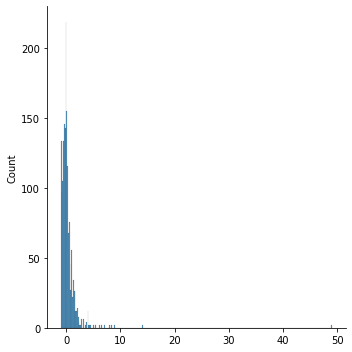

In [26]:
sns.displot(price_changes)

In [357]:
import collections
from datetime import timedelta

from ams.notebooks.twitter.twitter_ml_utils import EquityHolding


class MonteCarloMachine:
    from_dt = None
    to_dt = None
    current_dt_ndx = None
    holdings: List[EquityHolding] = []
    cash_total = None
    eod_cache = None
    trading_days = None
    price_threshold = None
    purchase_history: List[EquityHolding] = []
    
    def __init__(self, from_dt: datetime, to_dt: datetime, price_threshold: float, cash_startup=1000.0):
        self.from_dt = from_dt
        self.to_dt = to_dt
        self.cash_total = cash_startup
        self.eod_cache = dict()
        
        self.set_trading_days()
        self.current_dt_ndx = 0
        self.price_threshold = price_threshold
        
    def increment_day(self):
        current_dt_str = self.get_date_str(self.current_dt)
        next_ndx = self.current_dt_ndx + 1
        if next_ndx >= len(self.trading_days):
            print("Exceeded trading days upper bounds. Will sell")
            for h in self.holdings.copy():
                ticker_price = self.get_current_price(ticker=h.ticker)
                if ticker_price is None:
                    print(f"{h.ticker} price on {current_dt_str} not found.")
                current_price = h.purchase_price if ticker_price is None else ticker_price
                self.sell(eh=h, current_price=current_price)
            return
        
        self.current_dt_ndx = next_ndx
        print(f"Incrementing to {current_dt_str}.")
        
        # Any eh need selling?
        for h in self.holdings.copy():
            ticker_price = self.get_current_price(ticker=h.ticker)
            current_price = h.purchase_price if ticker_price is None else ticker_price
            if ticker_price is None or current_price > self.price_threshold or self.is_expired(h):
                self.sell(eh=h, current_price=current_price)
            
#             if ticker_price is None or self.is_expired(h):
#             if self.is_expired(h):
#                 self.sell(eh=h)
                
    def is_expired(self, eh: EquityHolding):
        is_ex = False
        if self.current_dt >= eh.expiry_dt:
            is_ex = True
        return is_ex
    
    def purchase(self, ticker: str, num_shares: int, days_to_hold: int):
        purchase_price = self.get_current_price(ticker=ticker)
        if purchase_price is None or purchase_price == 0:
            print(f"Price of {ticker} is zero. Will not buy.")
            return
        to_spend = purchase_price * num_shares
        if to_spend > self.cash_total:
            print(f"Not enough money to buy {num_shares} of {ticker}.")
            return
            
        expiry_dt = self.current_dt + timedelta(days=days_to_hold)
        
        eh = EquityHolding(ticker=ticker, purchase_price=purchase_price, num_shares=num_shares, 
                           purchase_dt=self.current_dt, expiry_dt=expiry_dt)
        self.cash_total -= to_spend
        
        print("Appending holdings.")
        self.holdings.append(eh)
        self.purchase_history.append(eh)
    
    def sell(self, eh: EquityHolding, current_price: float = None):
        if current_price is None:
            current_price = self.get_current_price(ticker=eh.ticker)
            
        sale_proceeds = current_price * eh.num_shares
        print(f"Profit: {current_price - eh.purchase_price}.")
        self.cash_total += sale_proceeds
        
        self.holdings.remove(eh)
        
    @property
    def current_dt(self):
        return self.trading_days[self.current_dt_ndx]
    
    def get_current_price(self, ticker: str):
        df = get_ticker_eod_data(ticker)
        current_dt_str = self.get_date_str(self.current_dt)
        
        df = df[df["date"] == current_dt_str]
        
        price = None
        if df is not None and df.shape[0] > 0:
            price = df.iloc[0]["close"]
            
        return price
    
    def get_date_str(self, dt: datetime):
        return date_utils.get_standard_ymd_format(dt)
    
    def get_dt(self, dt_str: str):
        return date_utils.parse_std_datestring(dt_str)
    
    def set_trading_days(self) -> List[datetime]:
        sample_eq = "AAPL"
        df = self.get_eod(ticker=sample_eq)
        from_str = self.get_date_str(self.from_dt)
        to_str = self.get_date_str(self.to_dt)
        df = df[(df["date"] >= from_str) & (df["date"] < to_str)]
        df.sort_values(by=["date"], inplace=True)
        trading_dt_strs = df["date"].to_list()
        self.trading_days = [self.get_dt(t) for t in trading_dt_strs]
    
    def get_eod(self, ticker: str) -> pd.DataFrame:
        if ticker not in self.eod_cache.keys():
            df = get_ticker_eod_data(ticker)
            self.eod_cache[ticker] = df
        
        return self.eod_cache[ticker]
    
    
    

In [353]:
import random

def was_purchased_prev(ticker: str, purchase_history: List[EquityHolding]):
    was_purch = False

    for ph in purchase_history:
        if ticker == ph.ticker:
            was_purch = True
            break

    return False


class TickerSelection():
    tickers_on_day = None
    mcm = None
    
    def __init__(self, mcm: MonteCarloMachine):
        self.mcm = mcm
        self.tickers_on_day = ticker_service.load_tickers_on_day()
    
    def get_random_ticker(self, date_str: str, omits: set):
        
        # Get list of available tickers on that day
        day_info = self.tickers_on_day[date_str]
        tickers = day_info.keys()
        tickers = tickers - omits
        
        ticker_list = list(tickers)
        shuffle(ticker_list)
        
        print(f'size of ticker_list: {len(ticker_list)}')
        
        tick_filtered = []
        for t in ticker_list:
            close = day_info[t]
            if close <= 50.:
                tick_filtered.append(t)
        
        t = None
        if len(tick_filtered) > 0:
            t = random.choice(tick_filtered)
            print(f"Choosing {t}.")
        return t
    
    def choose_ticker(self):
        omits = {ph.ticker for ph in self.mcm.purchase_history}
        date_str = mcm.get_date_str(self.mcm.current_dt)
        ticker = self.get_random_ticker(date_str, omits=omits)
        return ticker

In [ ]:
def try_purchase(ts: TickerSelection, mcm: MonteCarloMachine):
    ticker = ts.choose_ticker()
    if ticker is not None:
        mcm.purchase(ticker=ticker, num_shares=1, days_to_hold=days_to_hold)

In [359]:
year = 20
from_str = f"20{year:02d}-09-17"
to_str = f"20{year:02d}-11-23"

from_dt = date_utils.parse_std_datestring(from_str)
to_dt = date_utils.parse_std_datestring(to_str)

days_between = (to_dt - from_dt).days
days_to_hold = 1
price_threshold = 3000
cash_startup = 1000.

mcm = MonteCarloMachine(from_dt=from_dt, to_dt=to_dt, price_threshold=price_threshold, cash_startup=cash_startup)
ts = TickerSelection(mcm=mcm)

# for i in range(days_between):
#     try_purchase(ts=ts, mcm=mcm)
#     try_purchase(ts=ts, mcm=mcm)
#     try_purchase(ts=ts, mcm=mcm)
#     try_purchase(ts=ts, mcm=mcm)
#     print(mcm.cash_total)      
#     mcm.increment_day()

for i in range(500):
    try_purchase(ts=ts, mcm=mcm)

for i in range(days_between):
    mcm.increment_day()
            
assert(len(mcm.holdings) == 0)
print(mcm.cash_total)

roi = (mcm.cash_total - cash_startup) / cash_startup
print(roi)

c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


size of ticker_list: 2572
Choosing USEG.
Appending holdings.
size of ticker_list: 2571
Choosing XTLB.
Appending holdings.
size of ticker_list: 2570
Choosing MKD.
Appending holdings.
size of ticker_list: 2569
Choosing LTBR.
Appending holdings.
size of ticker_list: 2568
Choosing REXN.
Appending holdings.
size of ticker_list: 2567
Choosing PHUN.
Appending holdings.
size of ticker_list: 2566
Choosing AACG.
Appending holdings.
size of ticker_list: 2565
Choosing PLIN.
Appending holdings.
size of ticker_list: 2564
Choosing PTI.
Appending holdings.
size of ticker_list: 2563
Choosing VBIV.
Appending holdings.
size of ticker_list: 2562
Choosing HCCHR.
Appending holdings.
size of ticker_list: 2561
Choosing EYPT.
Appending holdings.
size of ticker_list: 2560
Choosing MEIP.
Appending holdings.
size of ticker_list: 2559
Choosing IEA.
Appending holdings.
size of ticker_list: 2558
Choosing NURO.
Appending holdings.
size of ticker_list: 2557
Choosing SMMCW.
Appending holdings.
size of ticker_list: 2556

Appending holdings.
size of ticker_list: 2420
Choosing CETX.
Appending holdings.
size of ticker_list: 2419
Choosing LKCO.
Appending holdings.
size of ticker_list: 2418
Choosing NOVSW.
Appending holdings.
size of ticker_list: 2417
Choosing BOXL.
Appending holdings.
size of ticker_list: 2416
Choosing APM.
Appending holdings.
size of ticker_list: 2415
Choosing CDTX.
Appending holdings.
size of ticker_list: 2414
Choosing PAEWW.
Appending holdings.
size of ticker_list: 2413
Choosing TXMD.
Appending holdings.
size of ticker_list: 2412
Choosing BNGOW.
Appending holdings.
size of ticker_list: 2411
Choosing SGBX.
Appending holdings.
size of ticker_list: 2410
Choosing HYACW.
Appending holdings.
size of ticker_list: 2409
Choosing NEPT.
Appending holdings.
size of ticker_list: 2408
Choosing SYPR.
Appending holdings.
size of ticker_list: 2407
Choosing BBI.
Appending holdings.
size of ticker_list: 2406
Choosing GMBL.
Appending holdings.
size of ticker_list: 2405
Choosing MDJH.
Appending holdings.
si

Appending holdings.
size of ticker_list: 2264
Choosing FTEK.
Appending holdings.
size of ticker_list: 2263
Choosing ONTX.
Appending holdings.
size of ticker_list: 2262
Choosing AGBAR.
Appending holdings.
size of ticker_list: 2261
Choosing GRNVR.
Appending holdings.
size of ticker_list: 2260
Choosing BKYI.
Appending holdings.
size of ticker_list: 2259
Choosing MHLD.
Appending holdings.
size of ticker_list: 2258
Choosing XNET.
Appending holdings.
size of ticker_list: 2257
Choosing BBCP.
Appending holdings.
size of ticker_list: 2256
Choosing SMTX.
Appending holdings.
size of ticker_list: 2255
Choosing SNSS.
Appending holdings.
size of ticker_list: 2254
Choosing JG.
Appending holdings.
size of ticker_list: 2253
Choosing GNFT.
Appending holdings.
size of ticker_list: 2252
Choosing CGIX.
Appending holdings.
size of ticker_list: 2251
Choosing KTRA.
Appending holdings.
size of ticker_list: 2250
Choosing CLBS.
Appending holdings.
size of ticker_list: 2249
Choosing AIKI.
Appending holdings.
size

Profit: -0.10000000000000009.
Profit: -0.16999999999999993.
Profit: -0.010000000000000009.
Profit: -0.040000000000000036.
Profit: 0.05000000000000002.
Profit: 0.14000000000000012.
Profit: 0.009999999999999898.
Profit: 0.06999999999999984.
Profit: 0.020000000000000462.
Profit: -0.0029999999999998916.
Profit: 0.11999999999999966.
Profit: -0.033999999999999975.
Profit: -0.0119999999999999.
Profit: 0.0.
Profit: 0.03000000000000025.
Profit: 0.0.
Profit: 0.09000000000000075.
Profit: 0.0.
Profit: -0.020000000000000018.
Profit: -0.03000000000000025.
Profit: 0.020000000000000462.
Profit: 0.010000000000000009.
Profit: -0.050000000000000044.
Profit: 0.0040000000000000036.
Profit: 0.0019999999999999463.
Profit: 0.03500000000000014.
Profit: -0.09999999999999964.
Profit: 0.004999999999999893.
Profit: 0.16999999999999993.
Profit: 0.11000000000000032.
Profit: 0.2450000000000001.
Profit: -0.15799999999999992.
Profit: 0.0.
Profit: -0.09000000000000008.
Profit: 0.010000000000000009.
Profit: -0.0300000000

Profit: -0.06000000000000005.
Profit: 0.04200000000000004.
Profit: -0.1299999999999999.
Profit: 0.020000000000000462.
Profit: 0.015000000000000003.
Profit: -0.20999999999999996.
Profit: 0.009999999999999787.
Profit: -0.06499999999999995.
Profit: 0.00899999999999998.
Profit: 0.04999999999999982.
Profit: -0.020000000000000018.
Profit: -0.16000000000000014.
Profit: 0.019999999999999574.
Profit: 0.18999999999999995.
Profit: 0.13000000000000034.
Profit: 0.0.
Profit: -0.07400000000000007.
Profit: -0.0050000000000000044.
Profit: 0.04999999999999982.
Profit: 0.0.
Profit: -0.08000000000000007.
Profit: -0.009999999999999787.
Profit: 0.017000000000000015.
Profit: 0.08999999999999986.
Profit: -0.020000000000000018.
Profit: 0.0050000000000001155.
Profit: 0.019999999999999574.
Profit: 0.1200000000000001.
Profit: 0.43999999999999995.
Profit: 0.034999999999999254.
Profit: -0.23999999999999977.
Profit: -0.08000000000000007.
Profit: 0.17999999999999972.
Profit: 0.004999999999999893.
Profit: 0.0200000000

In [348]:
roi = (mcm.cash_total - cash_startup) / cash_startup
print(roi)

0.0
